In [17]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot
import csv

os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
#from lib.lib_ot import *
from lib.lib_lopt import *
from lib.geodesic import *
from lib.tools import *

In [18]:
def lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7):
    K=weights.shape[0]
    N0,d=X0_init.shape
    Ui_list=np.zeros((K,N0,d))
    weights=np.ascontiguousarray(weights)
    weights=weights.reshape(K,1,1)
    X0=X0_init
    for iter in range(numItermax):
        for i in range(K):
            Xi=Xi_list[i]
            pi=pi_list[i]
            Ui=lot_embedding(X0,Xi,p0,pi,numItermax=numItermax)
            Ui_list[i]=Ui
        U_bar=np.sum(Ui_list*weights,0)
        X_bar=X0+U_bar    
        error = np.sum((X_bar - X0)**2)
        X0=X_bar
        if error<=stopThr:
            break
        
    return X0

def lopt_barycenter(Xi_list,pi_list,X0_init,p0, weights,Lambda, numItermax=10000,stopThr=1e-7, numThreads=1):
    K=weights.shape[0]
    N0,d=X0_init.shape
    Ui_list=np.zeros((K,N0,d))
    weights=np.ascontiguousarray(weights)
    weights=weights.reshape((K,1,1))
    X0=X0_init
    for iter in range(numItermax):
        for i in range(K):
            Xi=Xi_list[i]
            pi=pi_list[i]
            Ui,pi_hat,Mi=lopt_embedding(X0,Xi,p0,pi,Lambda)
            Ui_list[i]=Ui
        U_bar=np.sum(Ui_list*weights,0)
        X_bar=X0+U_bar    
        error = np.sum((X_bar - X0)**2)
        X0=X_bar
        if error<=stopThr:
            break
    return X0

    
    

In [19]:
def opt_barycenter(measures_locations, measures_weights, X_init, b, weights,Lambda, numItermax=10000,
                            stopThr=1e-7, numThreads=1):
    r"""
    Solves the free support (locations of the barycenters are optimized, not the weights) Wasserstein barycenter problem (i.e. the weighted Frechet mean for the 2-Wasserstein distance), formally:

    .. math::
        \min_\mathbf{X} \quad \sum_{i=1}^N w_i W_2^2(\mathbf{b}, \mathbf{X}, \mathbf{a}_i, \mathbf{X}_i)

    where :

    - :math:`w \in \mathbb{(0, 1)}^{N}`'s are the barycenter weights and sum to one
    - the :math:`\mathbf{a}_i \in \mathbb{R}^{k_i}` are the empirical measures weights and sum to one for each :math:`i`
    - the :math:`\mathbf{X}_i \in \mathbb{R}^{k_i, d}` are the empirical measures atoms locations
    - :math:`\mathbf{b} \in \mathbb{R}^{k}` is the desired weights vector of the barycenter

    This problem is considered in :ref:`[1] <references-free-support-barycenter>` (Algorithm 2).
    There are two differences with the following codes:

    - we do not optimize over the weights
    - we do not do line search for the locations updates, we use i.e. :math:`\theta = 1` in
      :ref:`[1] <references-free-support-barycenter>` (Algorithm 2). This can be seen as a discrete
      implementation of the fixed-point algorithm of
      :ref:`[2] <references-free-support-barycenter>` proposed in the continuous setting.

    Parameters
    ----------
    measures_locations : list of N (k_i,d) array-like
        The discrete support of a measure supported on :math:`k_i` locations of a `d`-dimensional space
        (:math:`k_i` can be different for each element of the list)
    measures_weights : list of N (k_i,) array-like
        Numpy arrays where each numpy array has :math:`k_i` non-negatives values summing to one
        representing the weights of each discrete input measure

    X_init : (k,d) array-like
        Initialization of the support locations (on `k` atoms) of the barycenter
    b : (k,) array-like
        Initialization of the weights of the barycenter (non-negatives, sum to 1)
    weights : (N,) array-like
        Initialization of the coefficients of the barycenter (non-negatives, sum to 1)

    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    numThreads: int or "max", optional (default=1, i.e. OpenMP is not used)
        If compiled with OpenMP, chooses the number of threads to parallelize.
        "max" selects the highest number possible.


    Returns
    -------
    X : (k,d) array-like
        Support locations (on k atoms) of the barycenter


    .. _references-free-support-barycenter:
    References
    ----------
    .. [1] Cuturi, Marco, and Arnaud Doucet. "Fast computation of Wasserstein barycenters." International Conference on Machine Learning. 2014.

    .. [2]  Álvarez-Esteban, Pedro C., et al. "A fixed-point approach to barycenters in Wasserstein space." Journal of Mathematical Analysis and Applications 441.2 (2016): 744-762.

    """

    #nx = get_backend(*measures_locations,*measures_weights,X_init)

    iter_count = 0
    

    K= measures_locations.shape[0]
    k,d = X_init.shape
    
    mass_list=np.sum(measures_weights,1)
    mass_max=mass_list.max()
    mass_0=np.sum(b)

    X = X_init
    
    # log_dict = {}
    #displacement_square_norms = []

    displacement_square_norm = stopThr + 1.
    N0=b.shape[0]
    b0=np.zeros(N0+1)
    b0[0:N0]=b
    b0[-1]=mass_max
    while (displacement_square_norm > stopThr and iter_count < numItermax):
        T_sum = np.zeros((k, d))
        for k in range(K):
        #for (measure_locations_i, measure_weights_i, weight_i) in zip(measures_locations, measures_weights,  weights):
            measure_locations_i=measures_locations[k]
            measure_weights_i=measures_weights[k]
            weight_i=weights[k]
            
            mass_i=mass_list[k]
            N_i=measure_weights_i.shape[0]
            
            measure_weights_i0=np.zeros(N_i+1)
            measure_weights_i0[0:N_i]=measure_weights_i 
            measure_weights_i0[-1]=mass_0+mass_max-mass_i
            
            M_i0=np.zeros((N0+1,N_i+1))
            M_i = cost_matrix_d(X, measure_locations_i)-2*Lambda
            M_i0[0:N0,0:N_i]=M_i
            #T_i = ot.emd(b, measure_weights_i, M_i, numThreads=numThreads)
            T_i0=ot.emd(b0, measure_weights_i0, M_i0,numItermax=numItermax,numThreads=numThreads)
            T_i=T_i0[0:N0,0:N_i]
            T_sum = T_sum + weight_i * 1. / b[:,None] * np.dot(T_i, measure_locations_i)
        displacement_square_norm = np.sum((T_sum - X)**2)
        X = T_sum
        iter_count += 1


    return X

In [39]:
def row_to_numpy(row):
    data={}
    row2=row.copy()
    data['label']=row2['label']
    del row2['label']
    N=len(row2)
    np_array=np.array(list(row2.values()),dtype=np.float64)
    np_array=np_array.reshape((int(np_array.shape[0]/3),3))
    p=np_array[:,2]
    D=p>0
    p_take=p[D]
    p_take=p_take/np.sum(p_take)
    np_array_take=np_array[D]
    N=np_array_take.shape[0]
    data = np.hstack((np_array_take[:,0:2],p_take.reshape((N,1)),np.ones((N,1))/N))
    return data

In [73]:
#load and convert data 
with open('experiment/data/MNIST/train.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    data_list=list()
    for row in reader:
        data=row_to_numpy(row)
        data_list.append(data)
torch.save(data_list,'experiment/data/MNIST/train_list.pt')

with open('experiment/data/MNIST/test.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    data_list=list()
    for row in reader:
        data=row_to_numpy(row)
        data_list.append(data)
torch.save(data_list,'experiment/data/MNIST/test_list.pt')



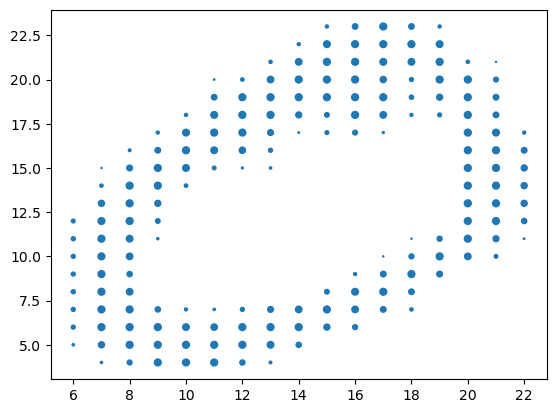

In [90]:
# load data, plot

MNIST_list=torch.load('experiment/data/MNIST/train_list.pt')
index_list=np.array([1,3,4])
i=1
X1=MNIST_list[i][:,0:2]
plt.scatter(X1[:,0], X1[:,1], s=3000*p1, alpha=1)
data_list=list()
for i,index in enumerate(index_list):
    data=MNIST_list[index]
    data_list.append(data)


data={}
data['0']=data_list
torch.save(data,'experiment/data/MNIST/geodesic.pt')




total mass is 1.0
total mass is 1.0
total mass is 1.0


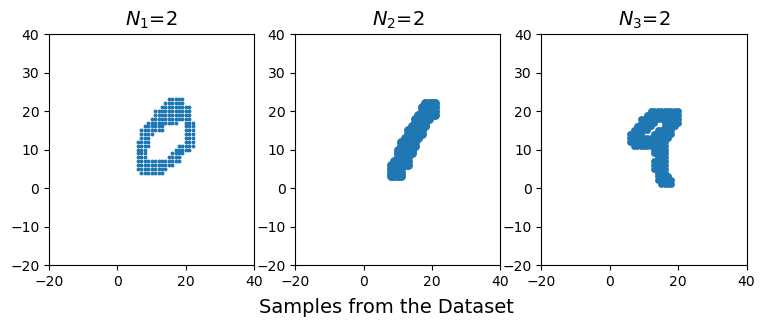

done
total mass is 1.5000000000000002
total mass is 1.5
total mass is 1.5


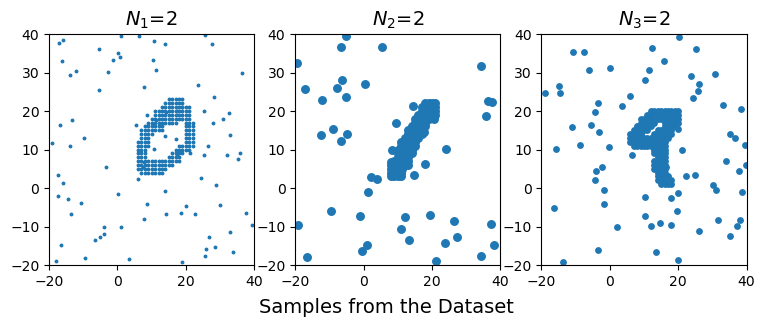

done
total mass is 1.75
total mass is 1.7500000000000002
total mass is 1.7499999999999998


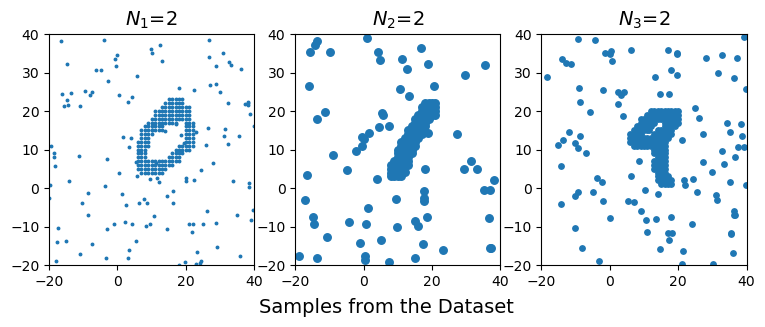

done


In [93]:
dataset=torch.load('experiment/data/MNIST/geodesic.pt')
data_list=dataset['0']

for per in [0.5,0.75]:
    data_Noise_list=list()
    for (i,data) in enumerate(data_list):
        Xi=data[:,0:2]
        pi=data[:,2]
        pi_uni=data[:,3]
        
        n_noise=int(Xi.shape[0]*per)
        noise_data=np.random.uniform(low=[-20,-20],high=[40,40],size=(n_noise,2))
        
        X_noise_i=np.concatenate((Xi,noise_data))
        pi_noise=np.concatenate((pi,np.ones(n_noise)/n_noise*per))
        pi_uni_noise=np.concatenate((pi_uni,np.ones(n_noise)/n_noise*per))
        #print(pi_noise.sum())
        data_noise=np.hstack((X_noise_i,pi_noise[:, np.newaxis],pi_uni_noise[:, np.newaxis]))
        data_Noise_list.append(data_noise)
        
    dataset[str(per)]=data_Noise_list
torch.save(dataset,'experiment/data/MNIST/geodesic1.pt')


for per in [0,0.5,0.75]:
    k=M
    datalist=dataset[str(per)]
    fig,ax=plt.subplots(1,k,figsize=(k*3,3))
    for i in range(k):
        data=datalist[i]
        X=data[:,0:2]
        p=data[:,2]
        print('total mass is', np.sum(p))
        ax[i].scatter(X[:,0],X[:,1],s=2000*p[i])
        ax[i].set_title(r'$N_%d$=%d'%(i+1,X[i].shape[0]),fontsize=14)
        ax[i].set_xlim(-20,40)
        ax[i].set_ylim(-20,40)
    fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
    plt.show()
    print('done')

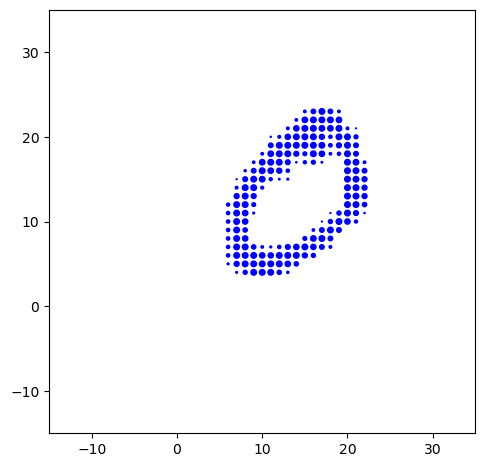

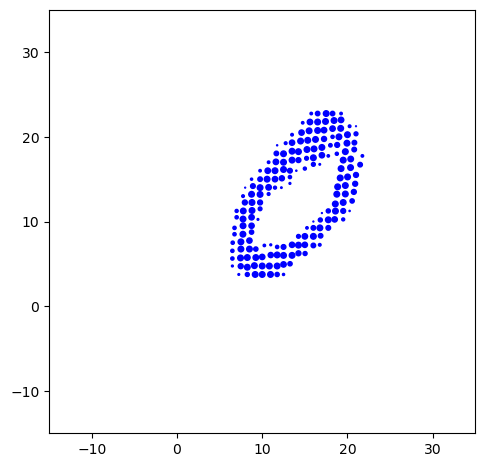

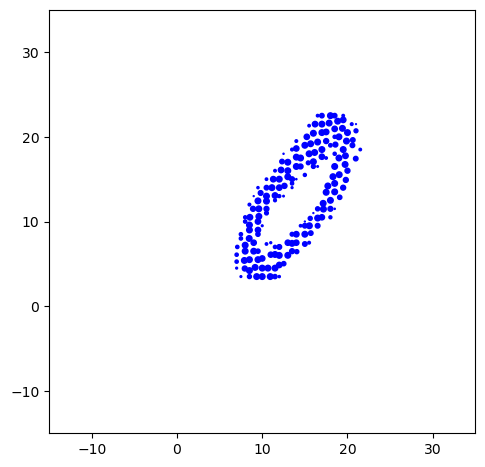

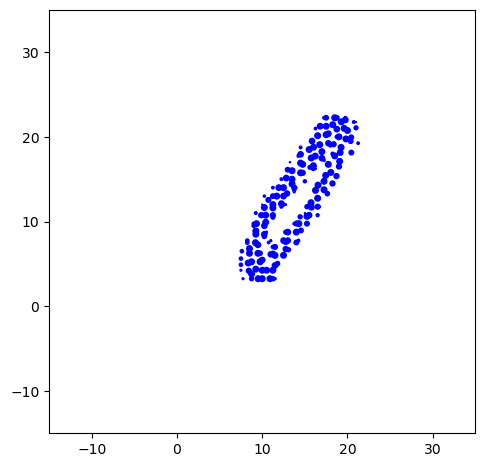

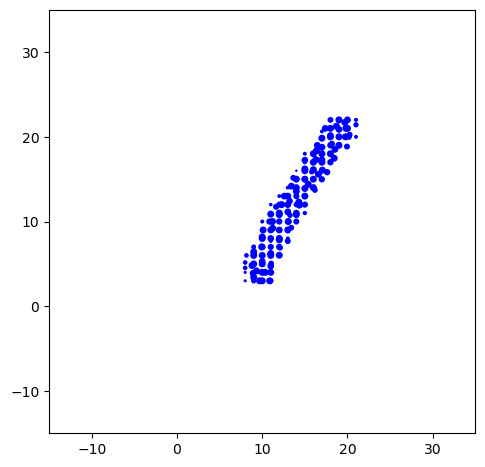

done


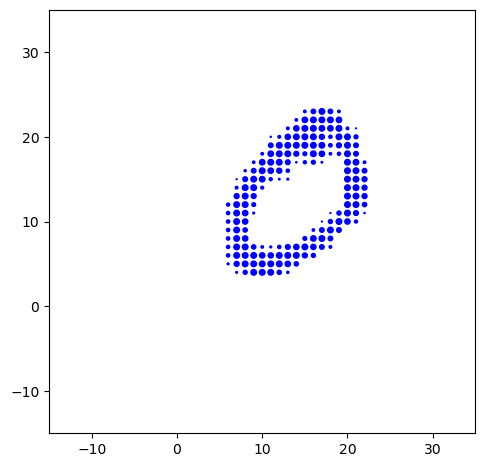

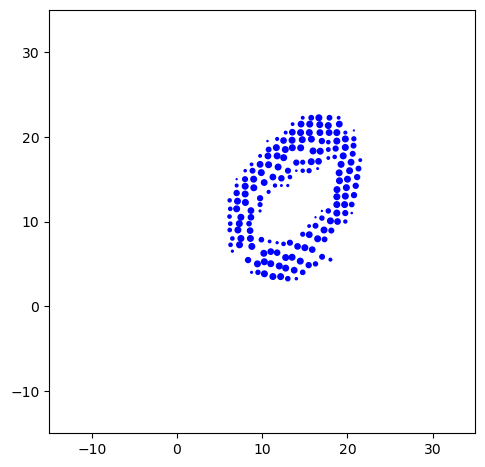

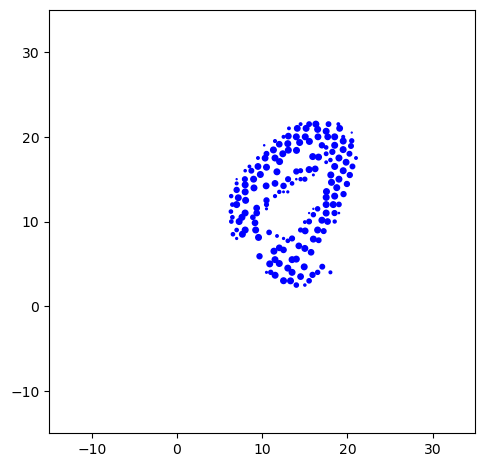

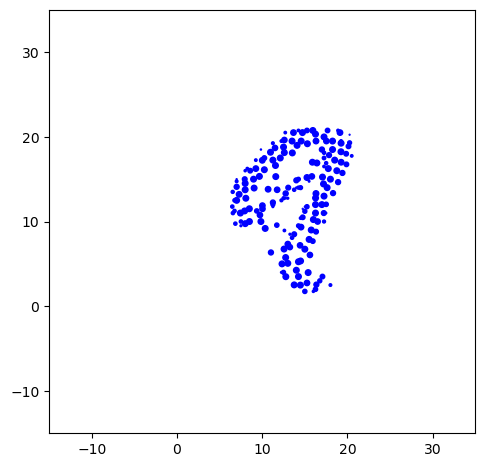

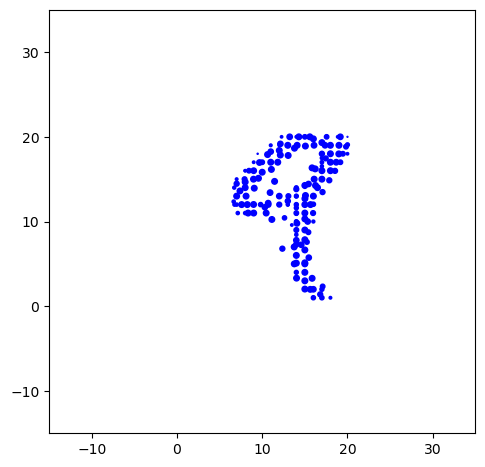

done


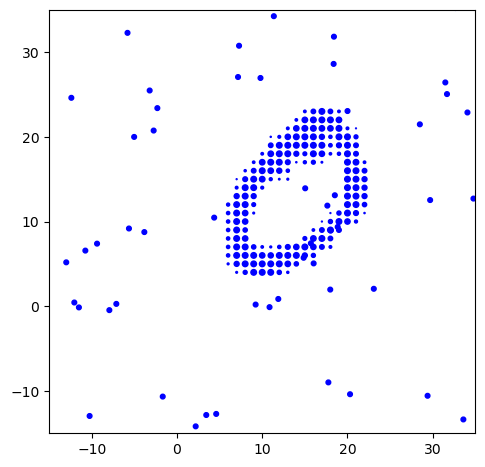

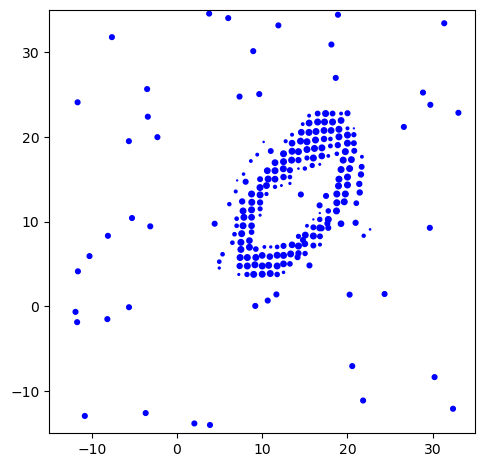

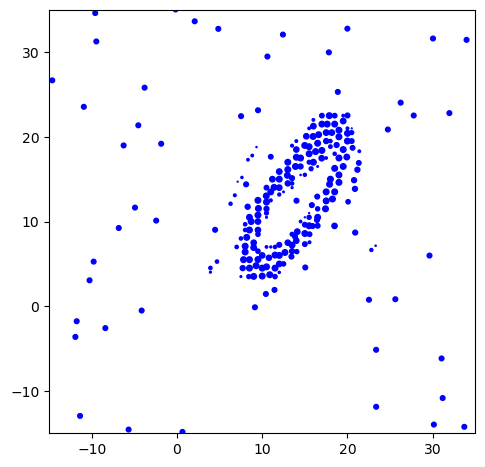

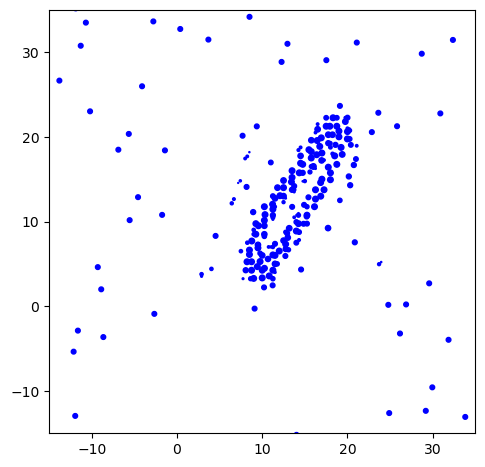

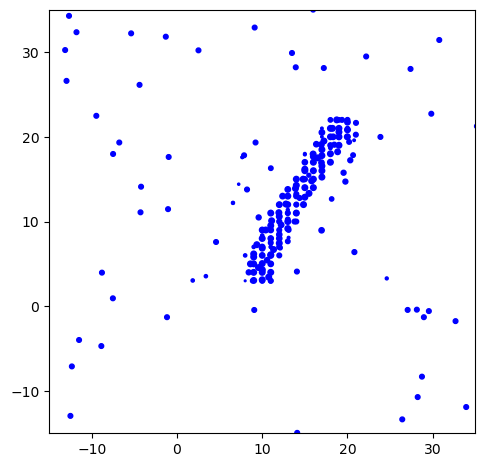

done


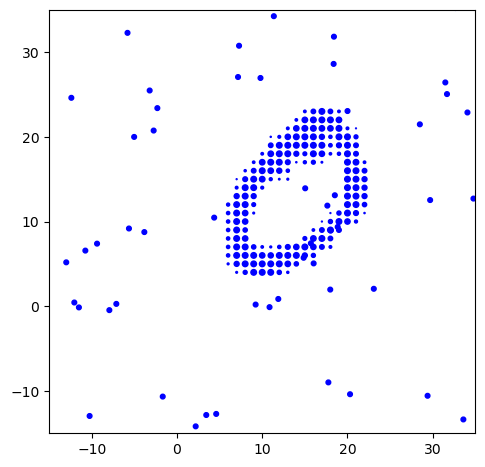

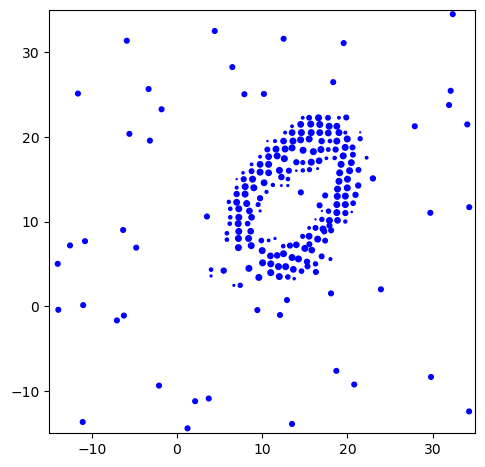

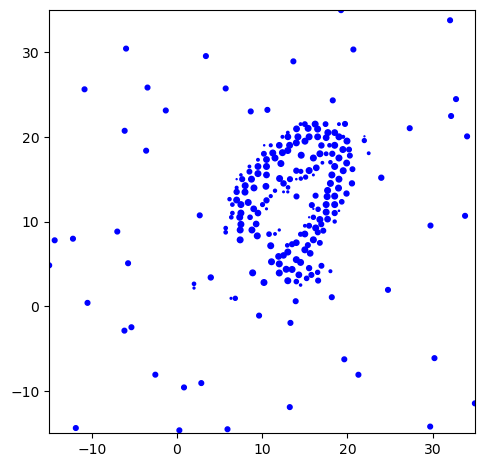

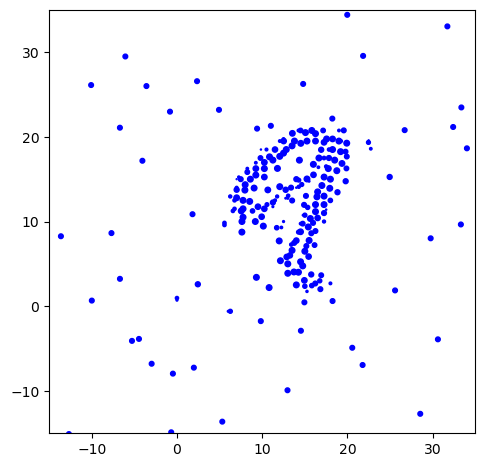

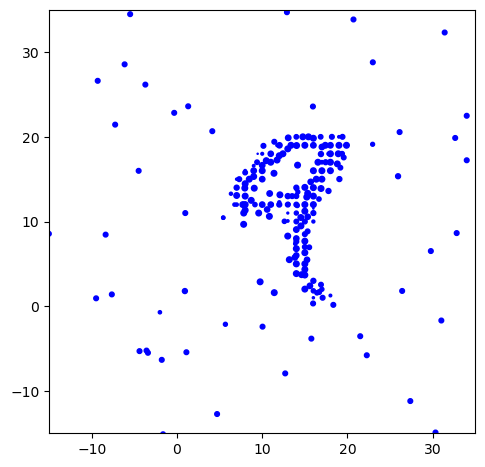

done


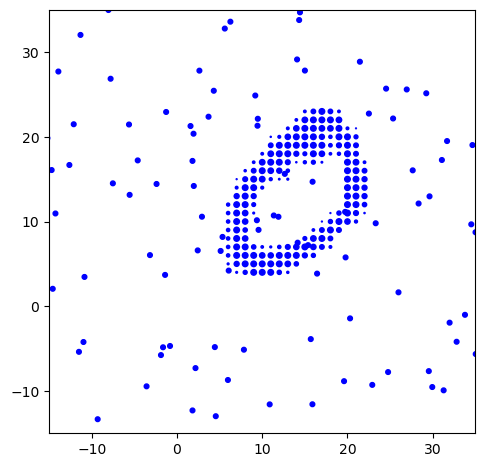

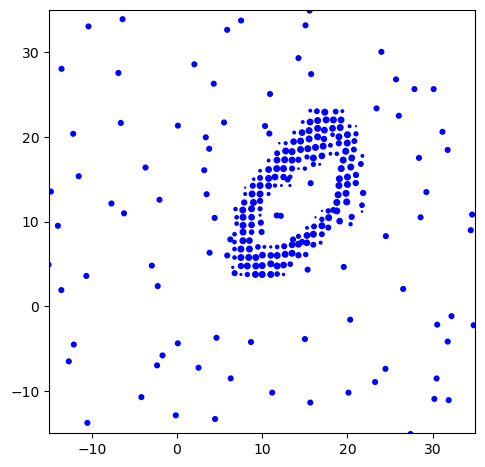

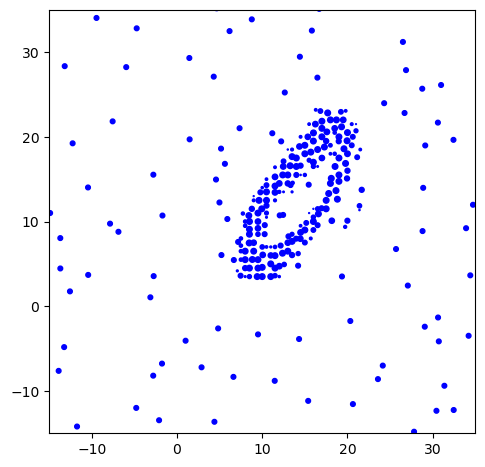

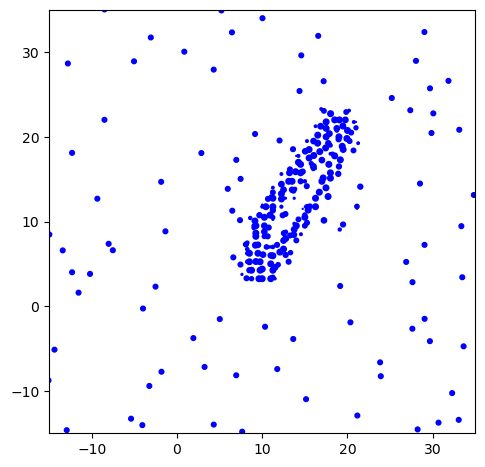

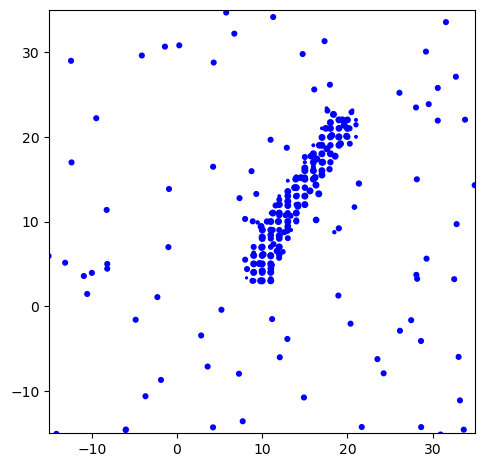

done


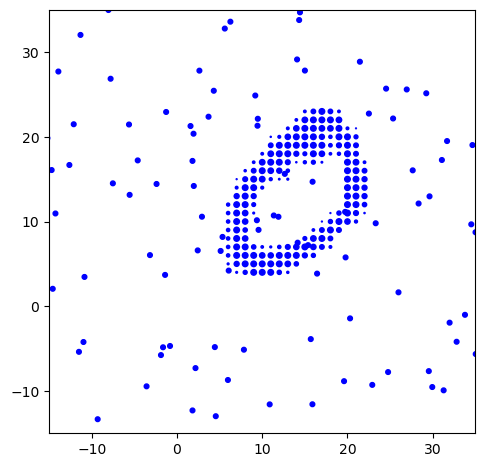

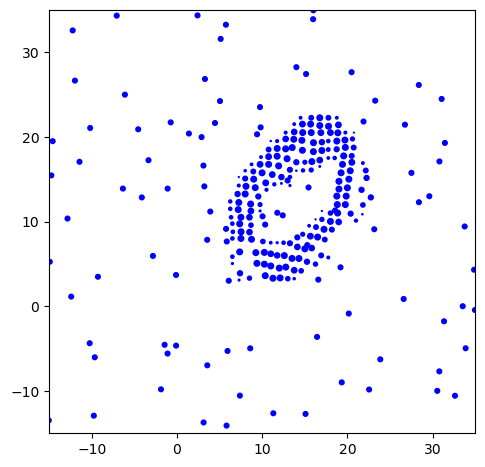

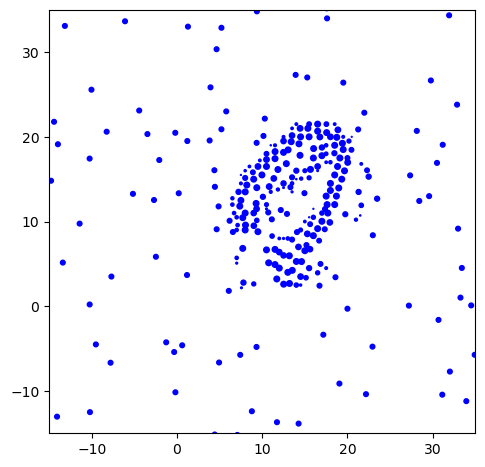

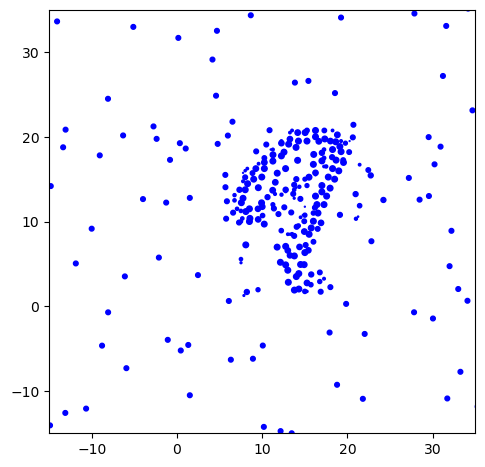

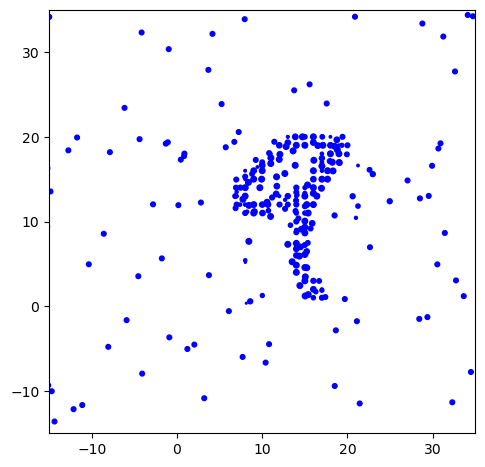

done


In [187]:
# OT geodesic
data_list=torch.load('experiment/geodesic/data/MNIST_list2.pt')
tN=5
L=[[0,1],[0,2]]

xlim=(-15,35)
ylim=(-15,35)
    
#fig,ax=plt.subplots(1,k,figsize=(k*3,3))
for label in [0,0.5,0.75]: 
    for (i,j) in L:
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)+'/'
        X,p=data_list['data_'+str(label)]
        Xi=X[i].copy()
        Xj=X[j].copy()
        pi=p[i]
        pj=p[j]
        Uj=lot_embedding(Xi,Xj,pi,pj)
        Xt_list_ot=ot_geodesic(Xi,Uj,np.linspace(0,1,tN))
    
        ind=0
        ot_result=list()
        for t in np.linspace(0,1,tN):
            Xt=Xt_list_ot[ind]
            name=save_path+'X_ot_t='+str(t)+'.pdf'
            scatter_2d(Xt,pi,xlim=xlim,ylim=ylim,name=name)
            ot_result.append((Xt,pi))
            ind+=1
   
        print('done')


In [10]:
#opt interporlation
#gamma=np.int64(gamma)
#gamma=np.array([[0,1],[0,0]])
#np.where(gamma[1]==1)[0].shape[0]


        
@nb.njit(nb.int64[:](nb.int64[:,:]),fastmath=True)
def gamma_to_T(gamma):
    n,m=gamma.shape
    T=np.zeros(n,dtype=np.int64)
    for i in range(n):
        ind=np.where(gamma[i,:]==1)[0]
        if ind.shape[0]==1:
            T[i]=ind[0]
    return T

    
    
        

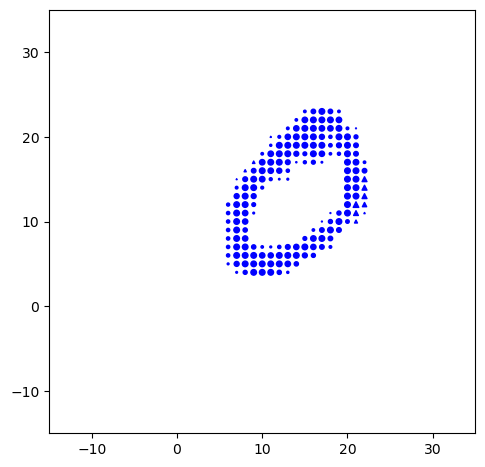

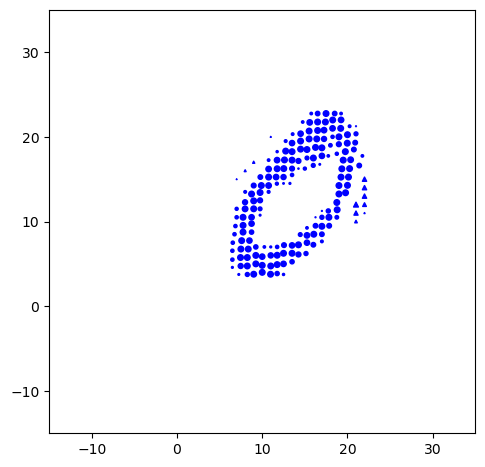

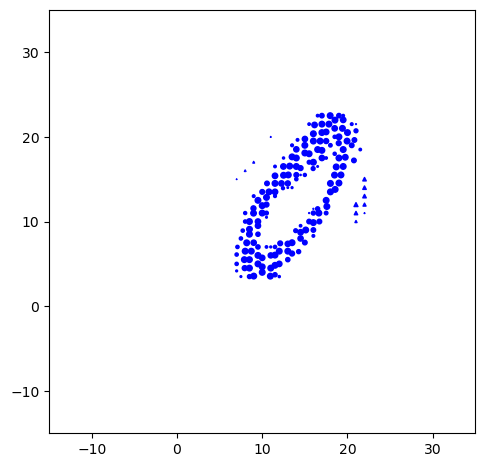

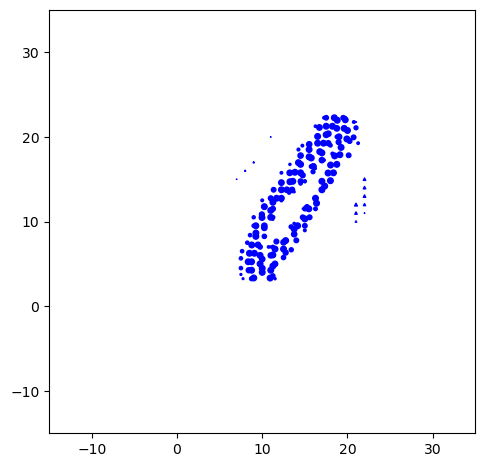

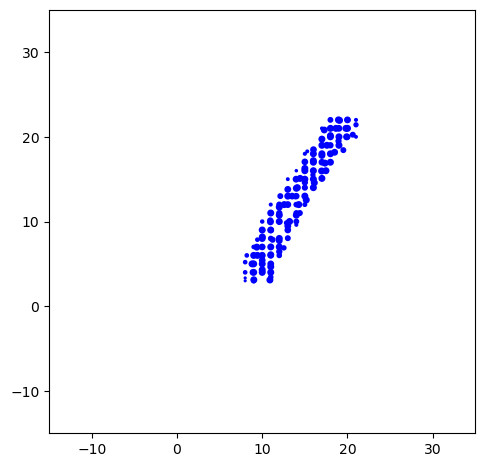

done


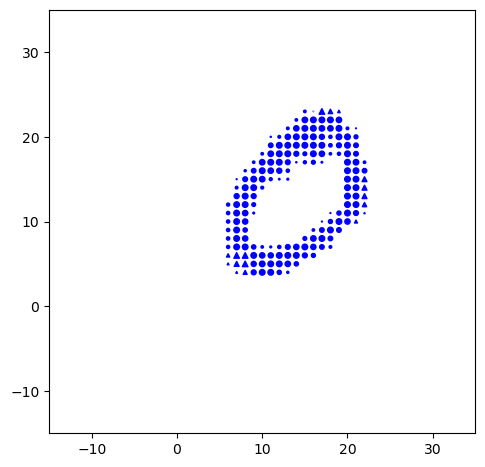

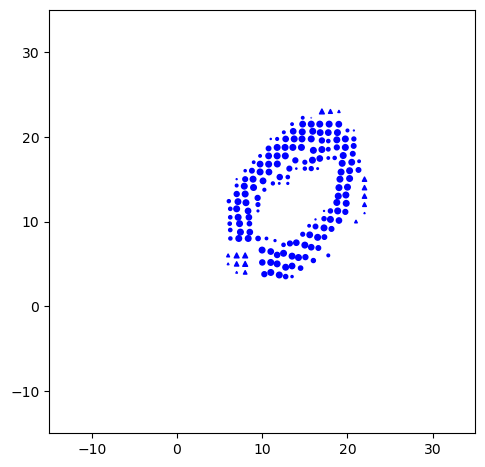

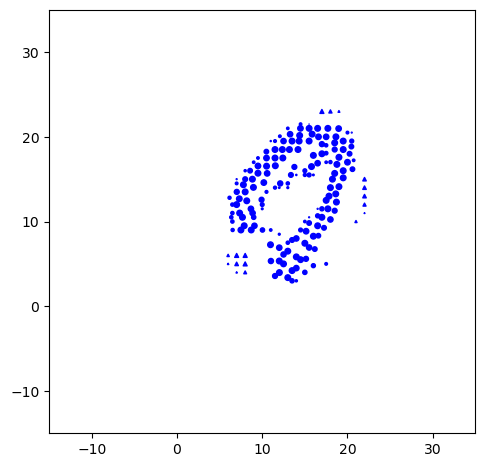

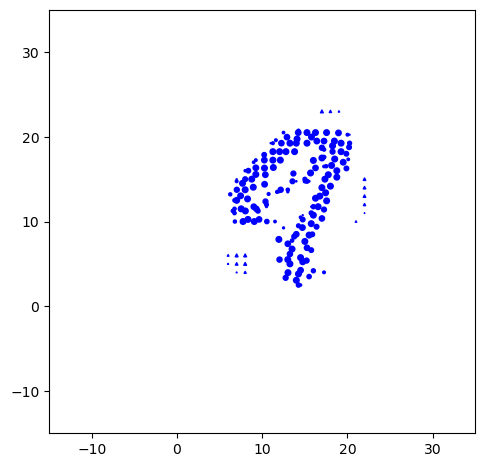

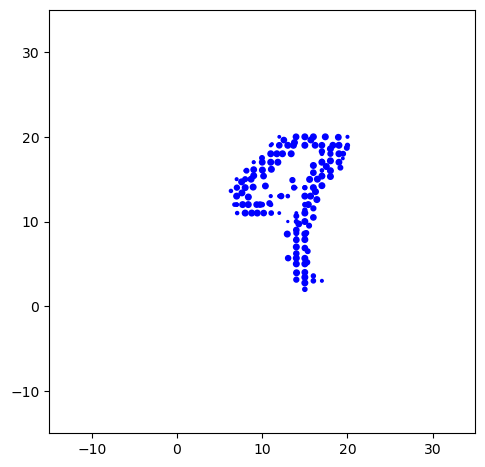

done


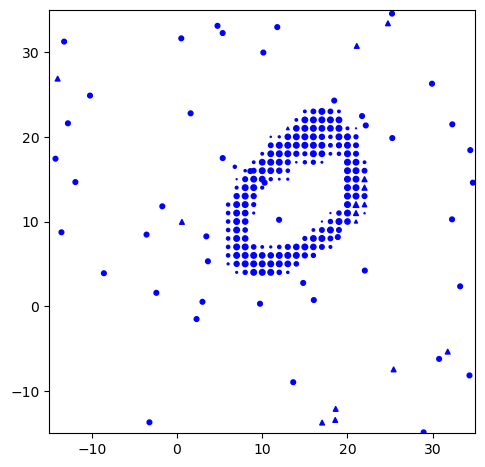

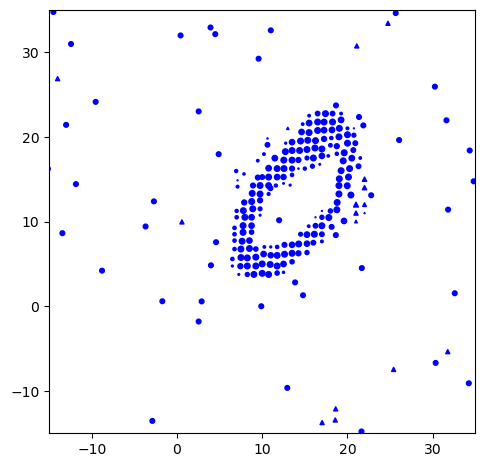

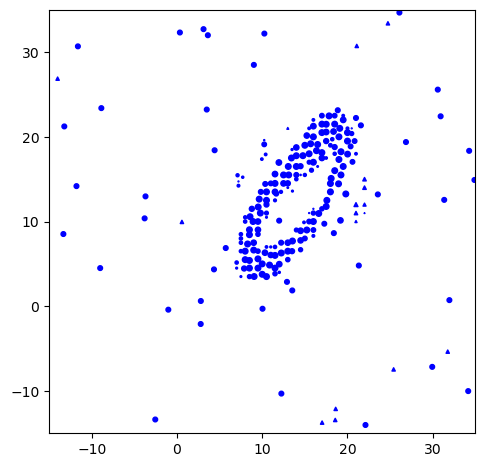

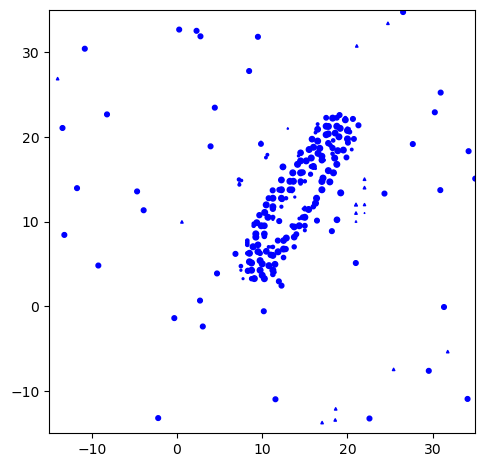

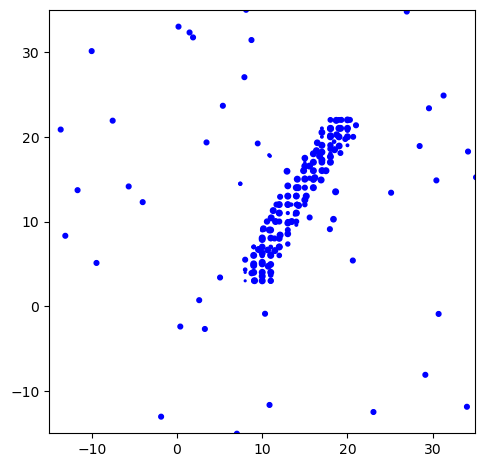

done


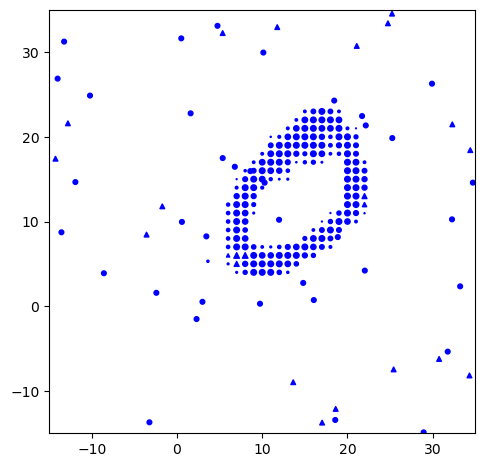

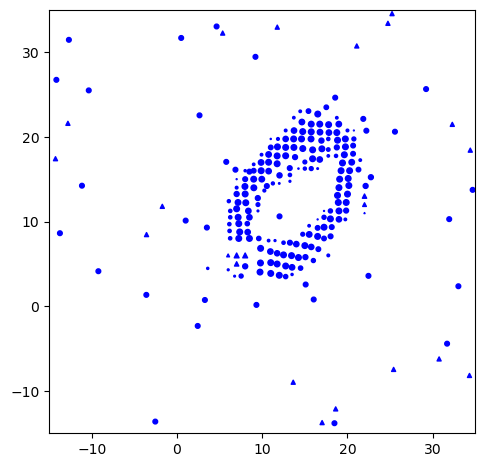

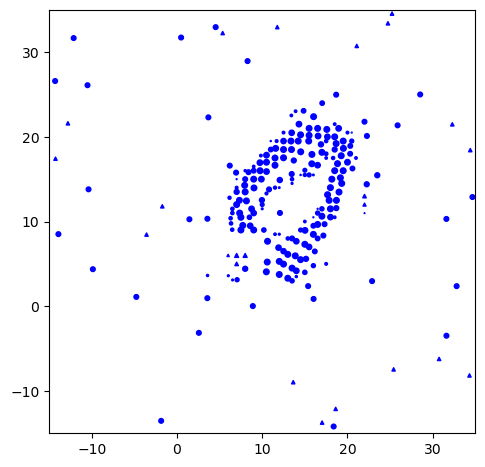

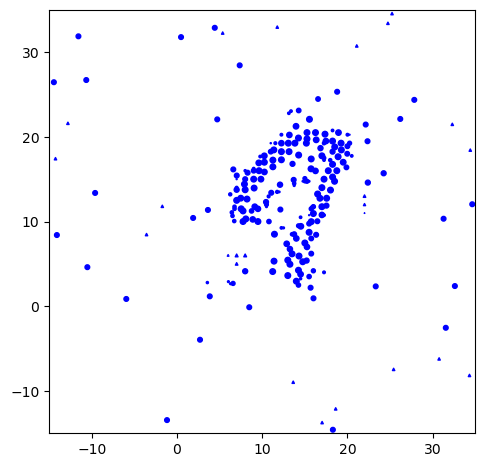

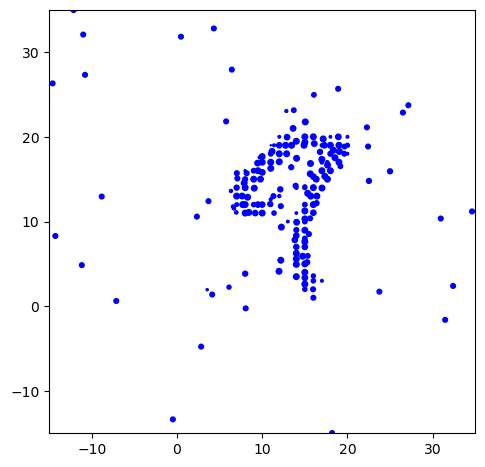

done


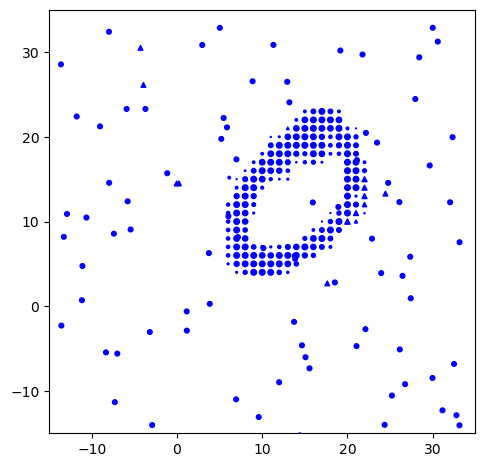

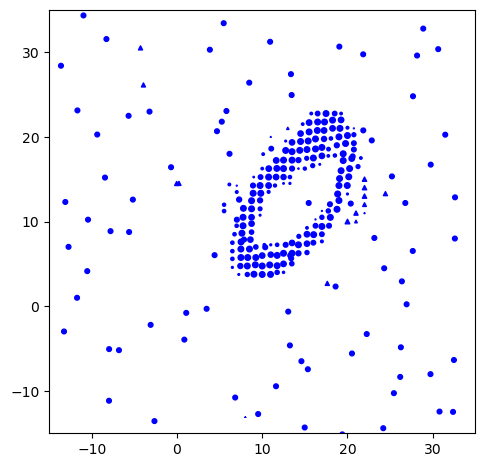

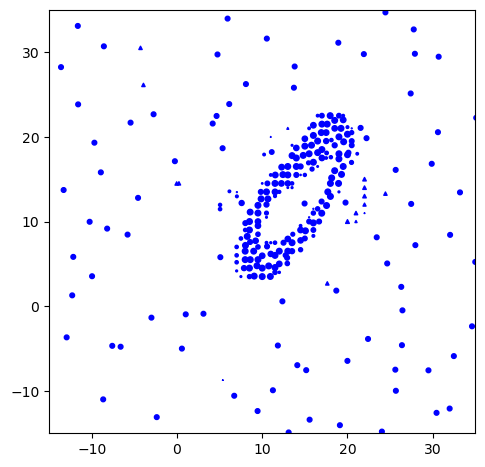

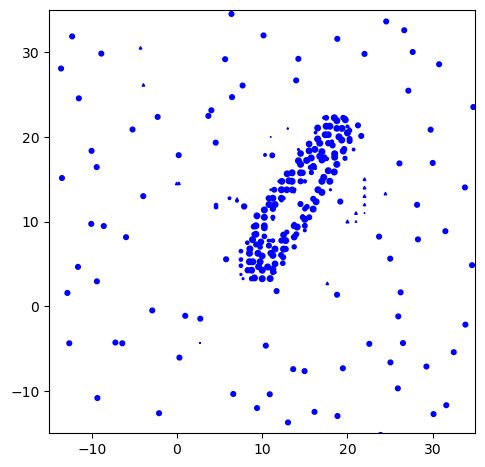

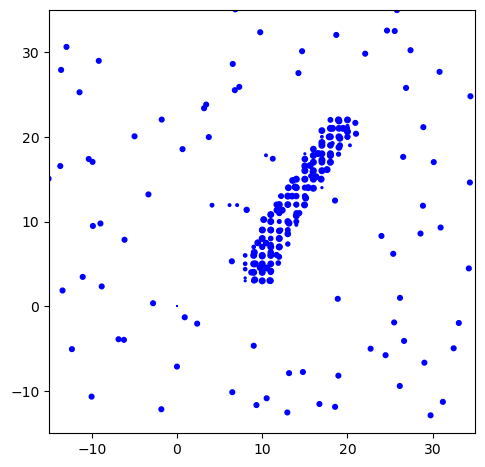

done


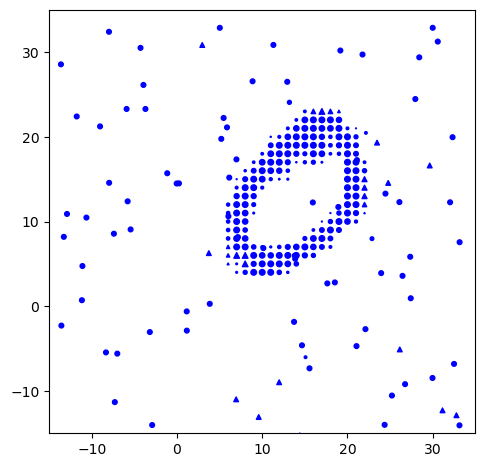

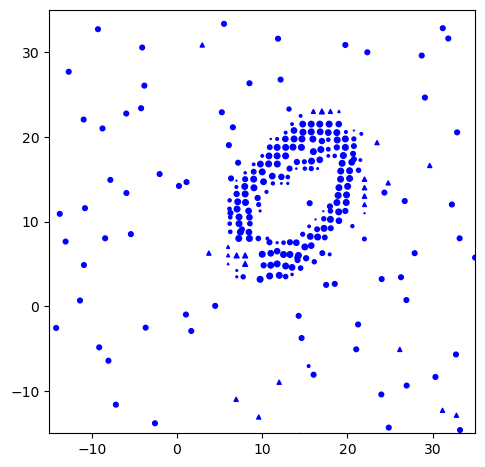

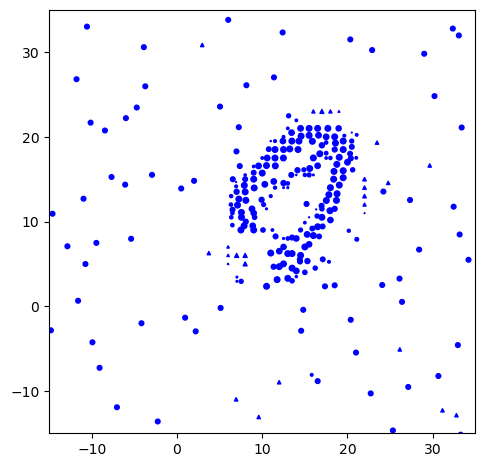

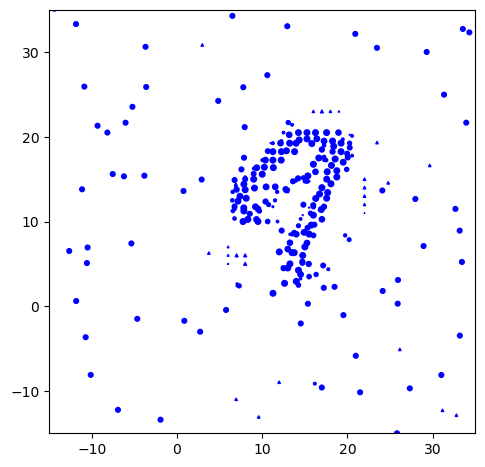

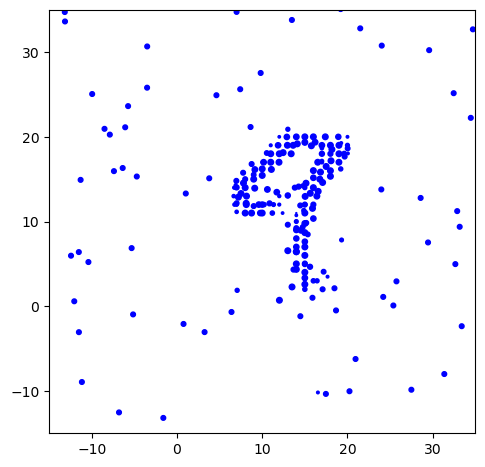

done


In [257]:
#opt interporlation
tN=5
L=[[0,1],[0,2]]
Lambda=20.0
data_list=torch.load('experiment/geodesic/data/MNIST_list2.pt')
xlim=(-15,35)
ylim=(-15,35)

for label in [0,0.5,0.75]: 
    for (i,j) in L:
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)+'/'
               
        X,p=data_list['data_'+str(label)]
        Xi=X[i].copy()
        Xj=X[j].copy()
        pi=p[i] #np.ones(Xi.shape[0])/Ni0
        pj=p[j] #np.ones(Xj.shape[0])/Nj0
        Uj,pj_hat,Mj=lopt_embedding(Xi,Xj,pi,pj,Lambda)
        Xt_list,pt,X_d,p_d=opt_interpolation(Xi,Uj,pi,pj_hat,np.linspace(0,1,tN))   # (X0,U1,p0,p1_hat,t_list)
       
        ind=0
        opt_result=[]
        for t in np.linspace(0,1,tN):
            Xt=Xt_list[ind]
            name=save_path+'X_opt_t='+str(t)+'.pdf'
            scatter_2d(Xt,pt,X_d=X_d,p_d=(1-t)*p_d,xlim=xlim,ylim=ylim,name=name)
            opt_result.append((Xt,pt,X_d,(1-t)*p_d))
            ind+=1
        torch.save(opt_result,save_path+'/opt_result.pt')
        print('done')
        

In [16]:
#LOT interpolation 
# compute barycenter 
data_list=torch.load('experiment/geodesic/data/MNIST_list2.pt')

X,p=data_list['data_0']
X1,X2,X3=(X[0],X[1],X[2])
p1,p2,p3=(p[0],p[1],p[2])
N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
p0=p1 #np.ones(N)/N
X0_init=X1
Xi_list=[X1,X2,X3]
pi_list=[p1,p2,p3]
weights=np.ones(3)/3
X0=lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7)

scatter_2d(X0,p0,xlim=xlim,ylim=ylim,name=name)
   


NameError: name 'gamma' is not defined

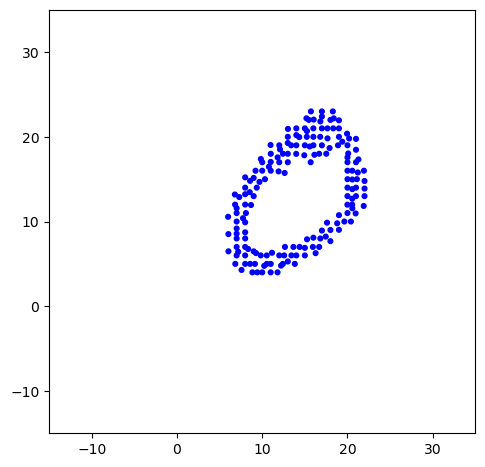

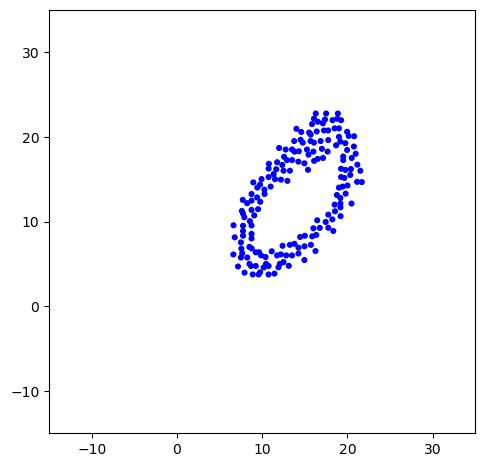

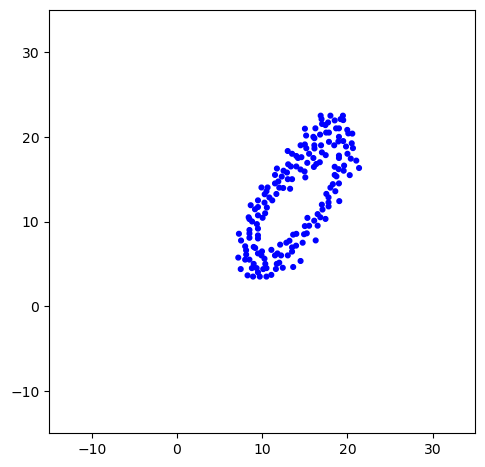

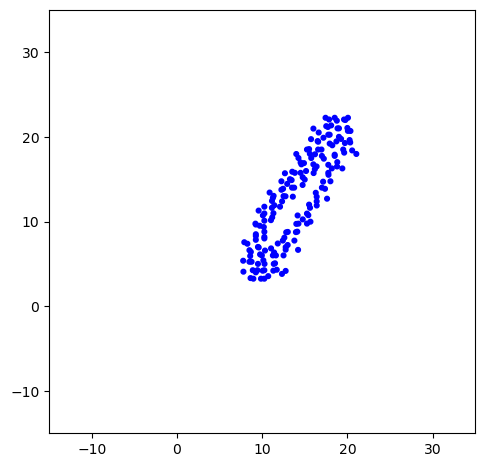

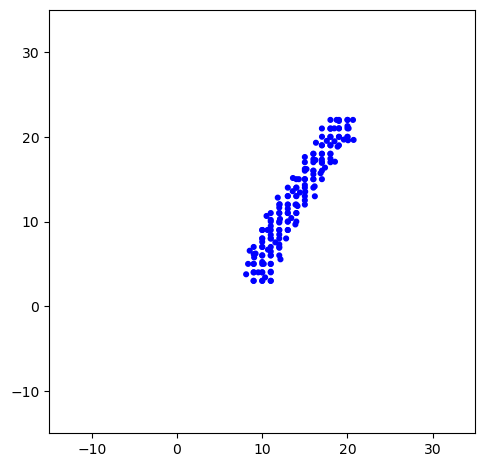

end


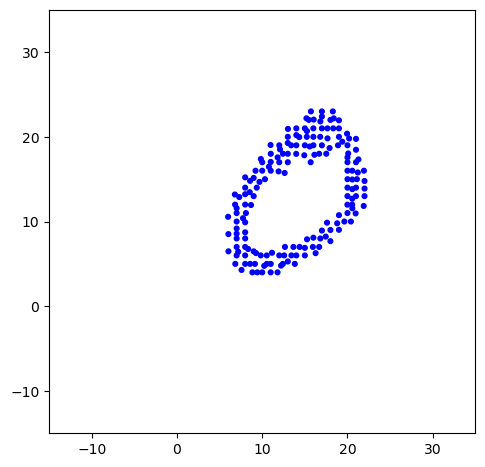

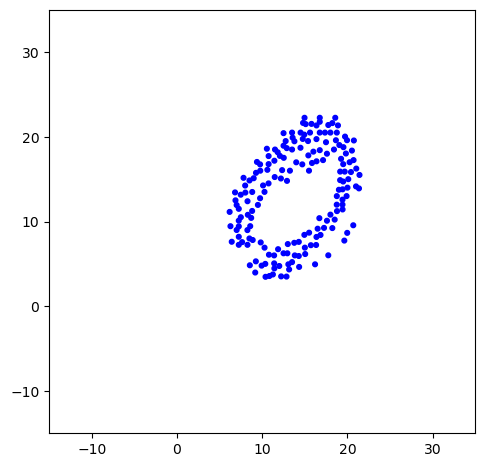

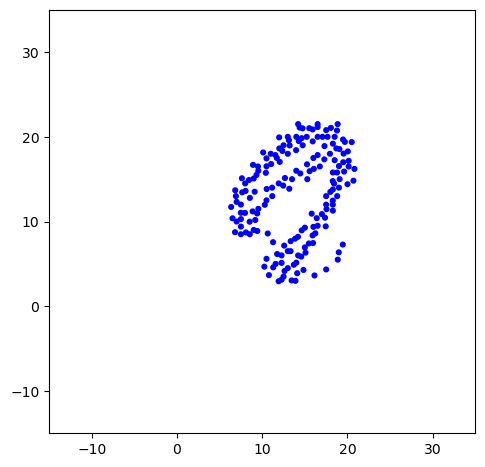

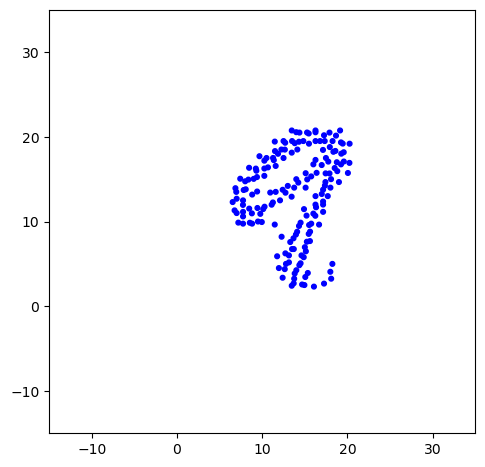

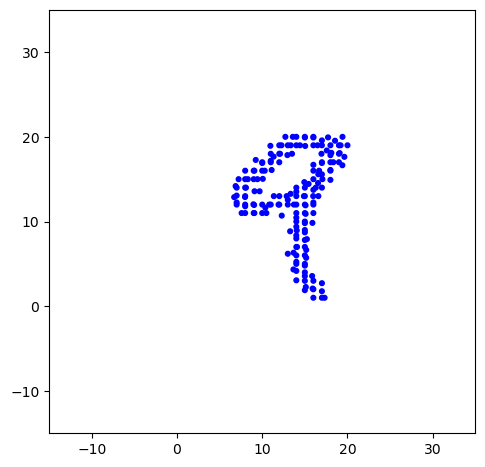

end


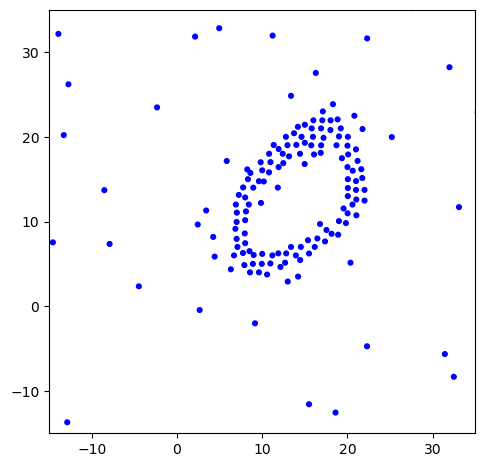

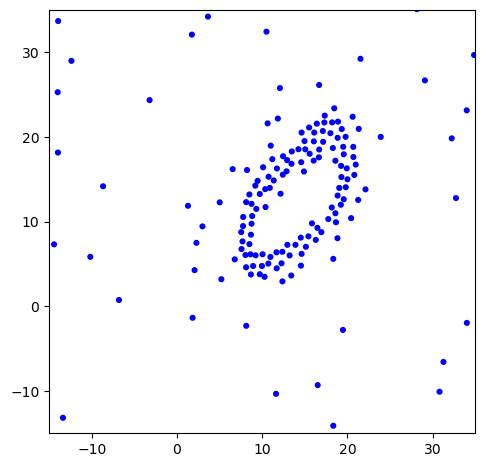

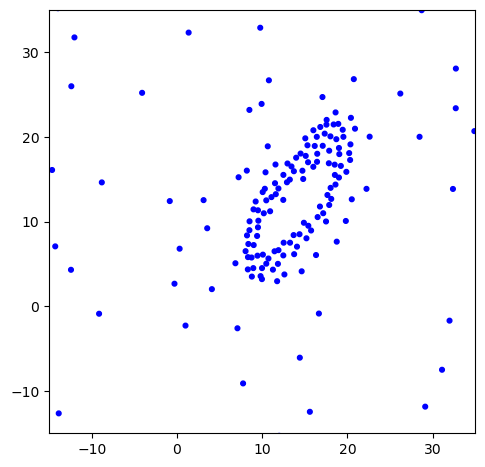

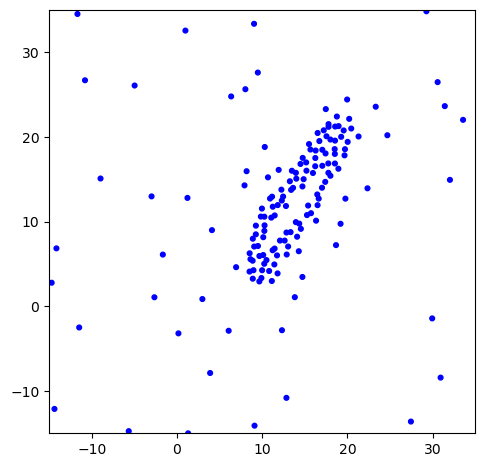

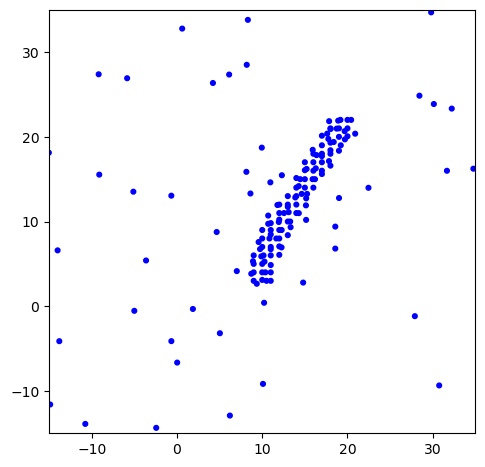

end


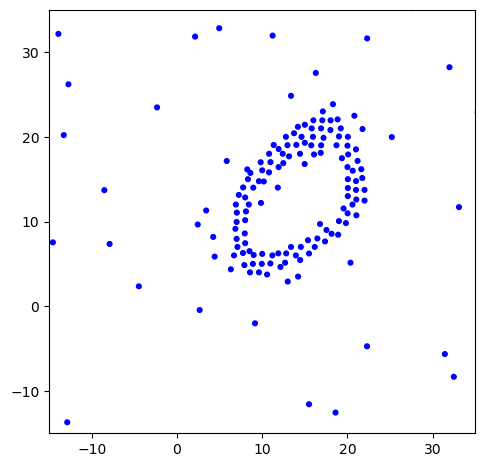

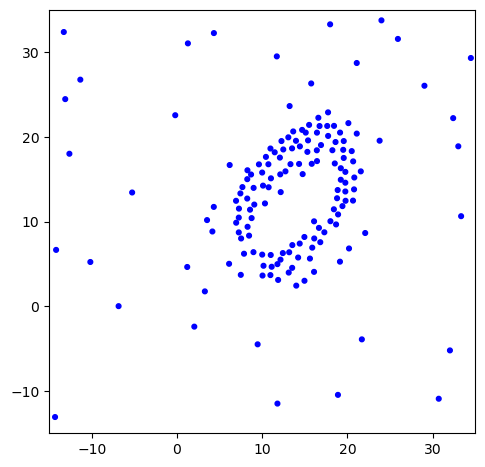

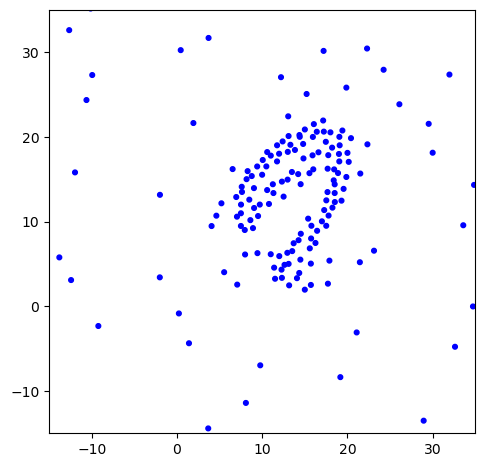

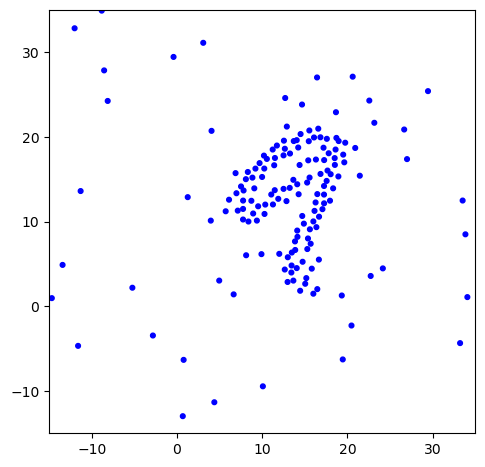

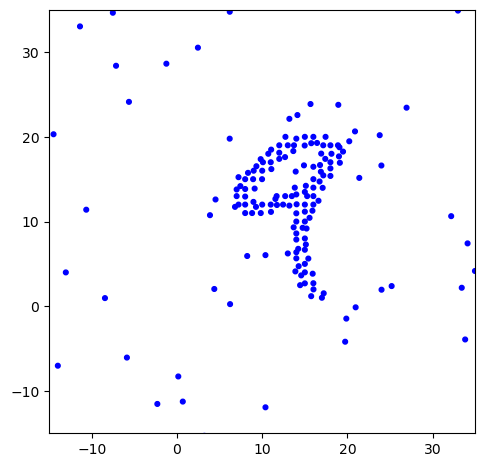

end


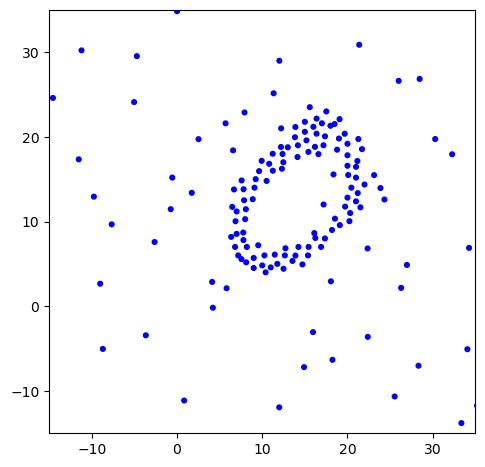

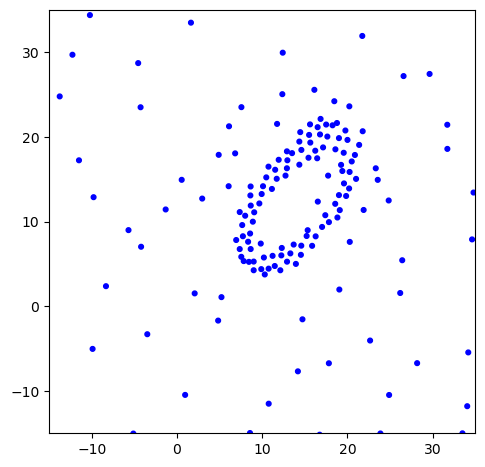

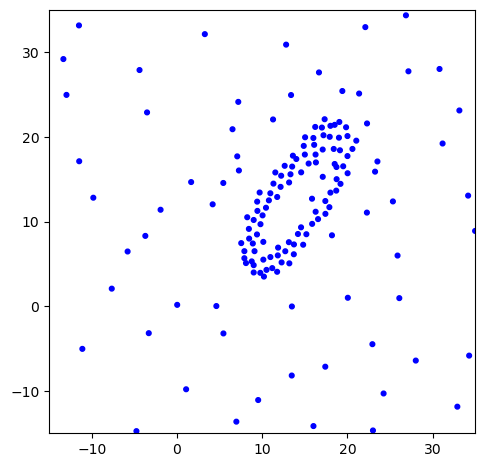

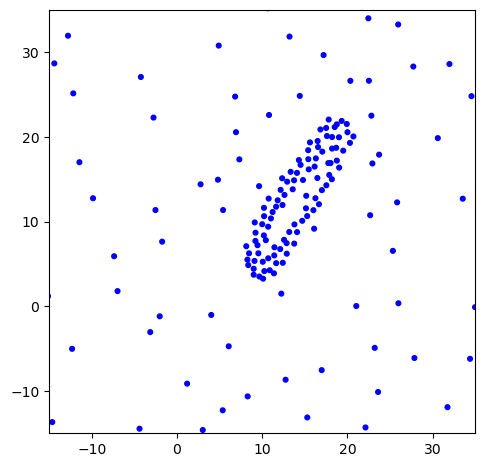

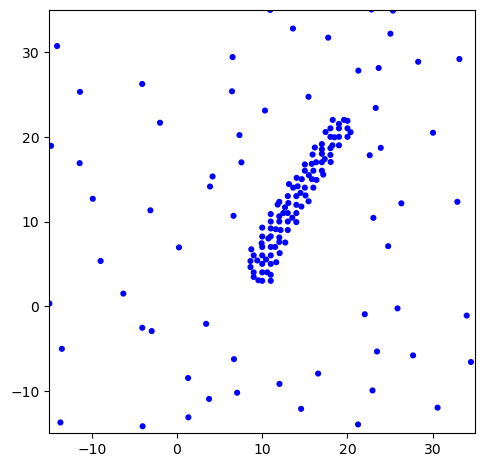

end


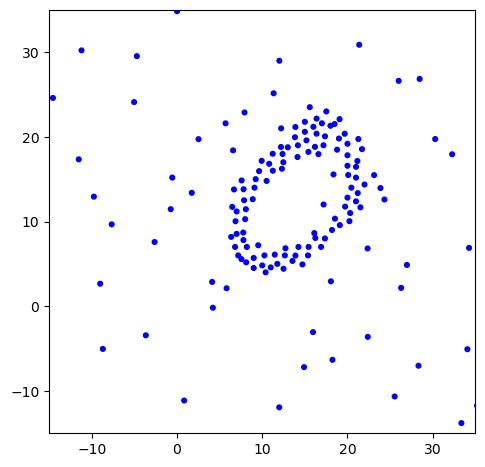

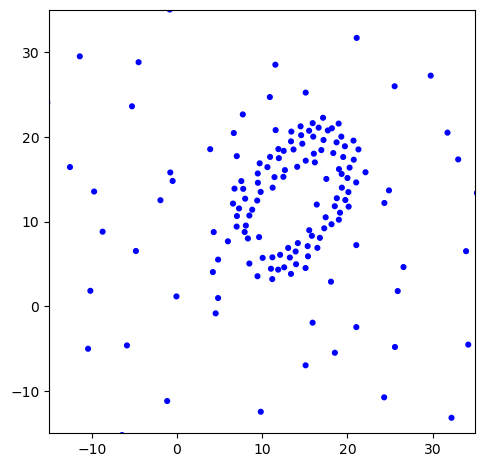

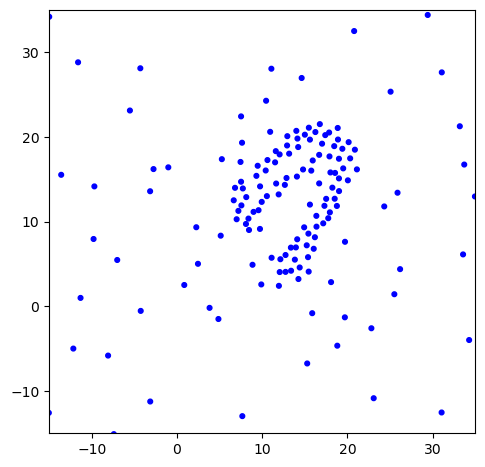

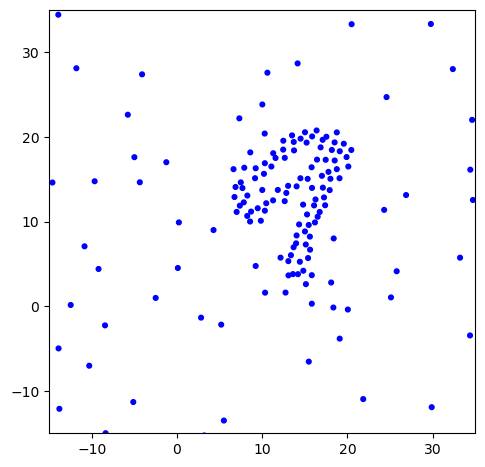

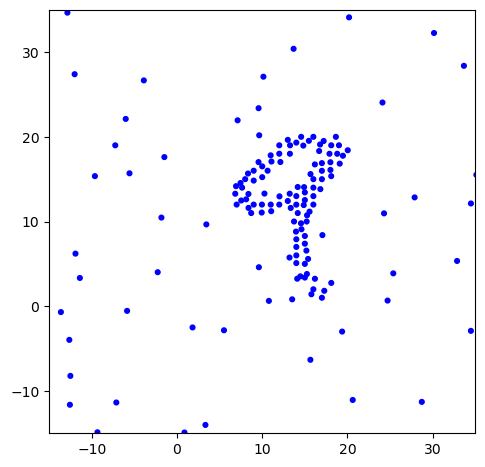

end


In [270]:
#LOT interpolation 
xlim=(-15,35)
ylim=(-15,35)

for label in [0,0.5,0.75]:
    # X1,X2,X3=(X[0],X[1],X[2])
    # p1,p2,p3=(p[0],p[1],p[2])
    # #N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
    # X0_init=np.random.uniform(low=[5,5],high=[25,25],size=[N00,2])
    # p0=np.ones(N00)/N00
    # Xi_list=[X1,X2,X3]
    # pi_list=[p1/np.sum(p1)*np.sum(p0),p2/np.sum(p1)*np.sum(p0),p3/np.sum(p3)*np.sum(p0)]
    # weights=np.ones(3)/3
    # X0=lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7)
    
    U_lot=list()
    
    X,p=data_list['data_'+str(label)]
    for k in range(M):
        Xk=X[k].copy()
        pk=p[k]
        pk=pk/np.sum(pk)*np.sum(p0)
        Uk_lot=lot_embedding(X0,Xk,p0,pk)
        U_lot.append(Uk_lot)
    #torch.save(U_lot,'experiment/geodesic/result/MNIST/U_lot'+str(label)+'.pt')
 
    for (i,j) in L:
        
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)
        Xi=X[i].copy()
        Xj=X[j].copy()
        Ui=U_lot[i]
        Uj=U_lot[j]

        #X_alpha=lot_geodesic(X0,Ui,Uj,alpha)

        Xt_list=lot_geodesic(X0,Ui,Uj,np.linspace(0,1,tN))
        ind=0
        lot_result=[]
        for t in np.linspace(0,1,tN):
            Xt=Xt_list[ind]
            name=save_path+'/'+'X_lot_t='+str(t)+'.pdf'
            scatter_2d(Xt,p0,xlim=xlim,ylim=ylim,name=name)
            lot_result.append((Xt,p0))
            ind+=1   
        torch.save(lot_result,save_path+'/lot_result.pt')
        print('end')
        

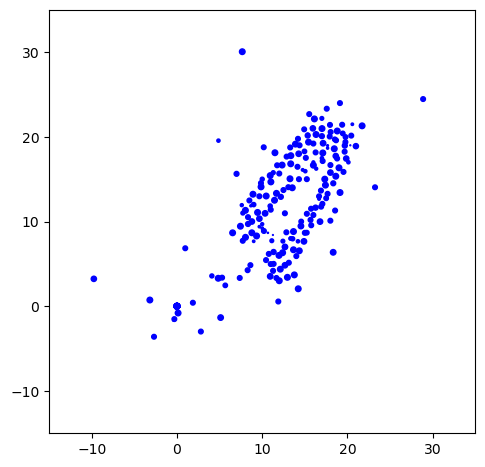

In [290]:
data_list=torch.load('experiment/geodesic/data/MNIST_list2.pt')
Lambda=20.0
X,p=data_list['data_0.5']
X1,X2,X3=(X[0],X[1],X[2])
p1,p2,p3=(p[0],p[1],p[2])
N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
p0=p1 #np.ones(N)/N
#N0=p1.shape[0]
X0_init=X1
X0_init=np.random.uniform([5,5],[25,25],[X1.shape[0],2])
Xi_list=[X1,X2,X3]
pi_list=[p1,p2,p3]
weights=np.ones(3)/3

X0=lopt_barycenter(Xi_list,pi_list,X0_init,p0,weights, Lambda, numItermax=10000,stopThr=1e-7)
#p0=p0
scatter_2d(X0,p0,xlim=xlim,ylim=ylim,name=name)

#X0=np.random.uniform(low=[5,5],high=[25,25],size=(N0,2))

label 0


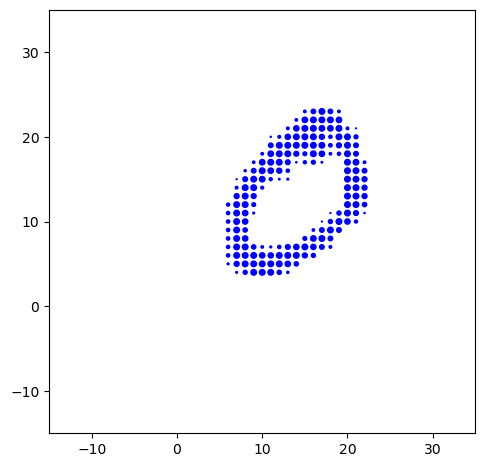

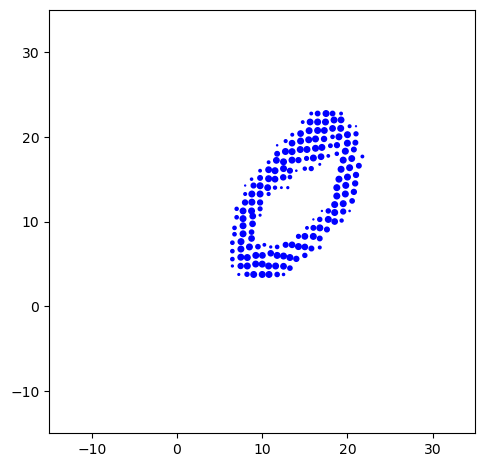

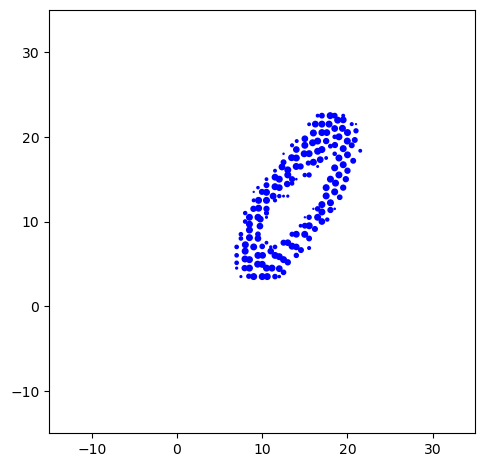

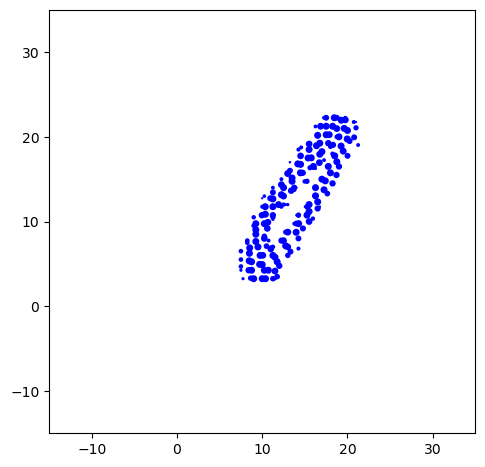

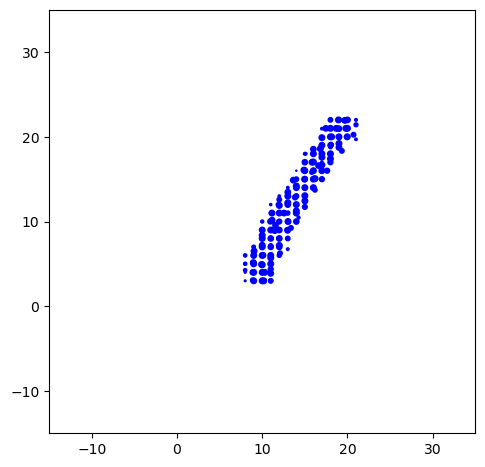

end


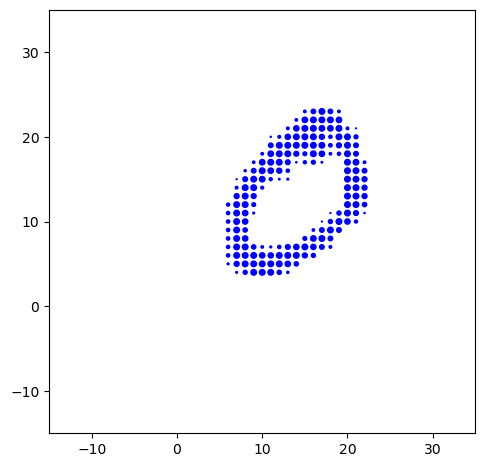

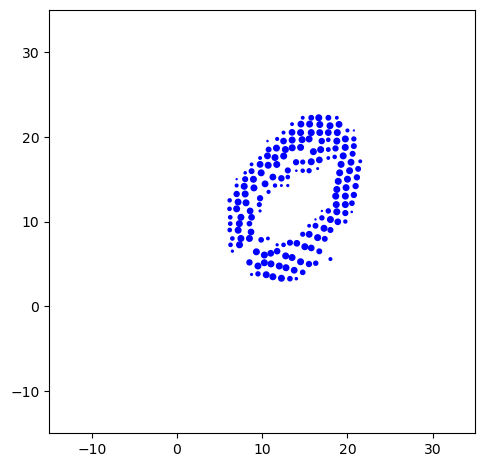

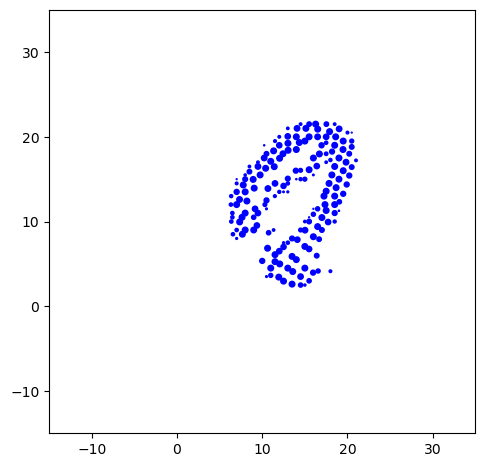

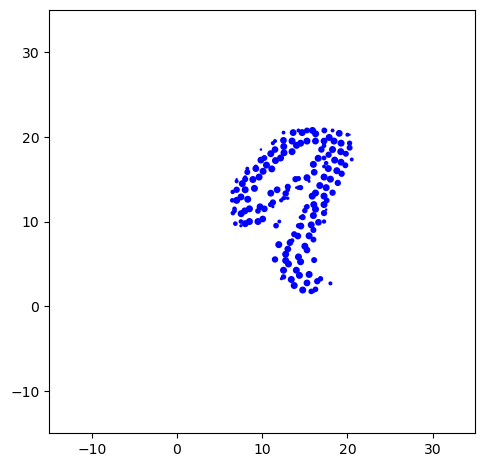

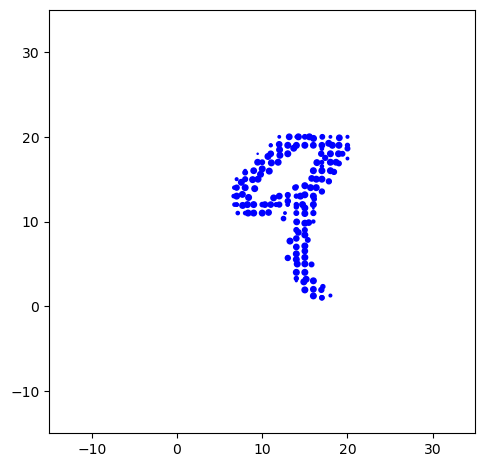

end
label 0.5


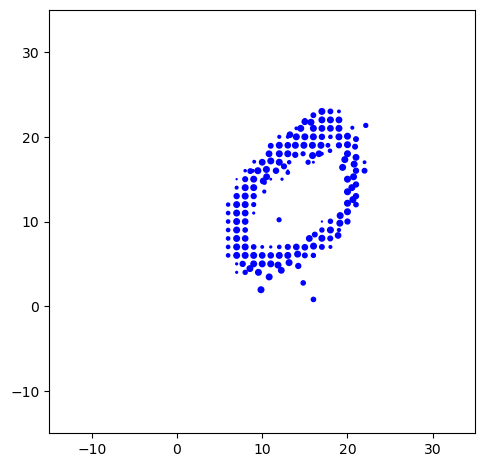

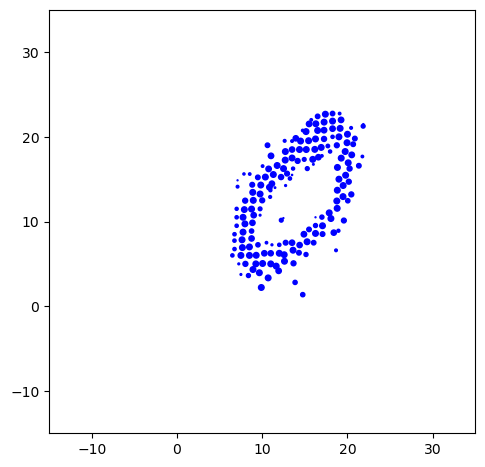

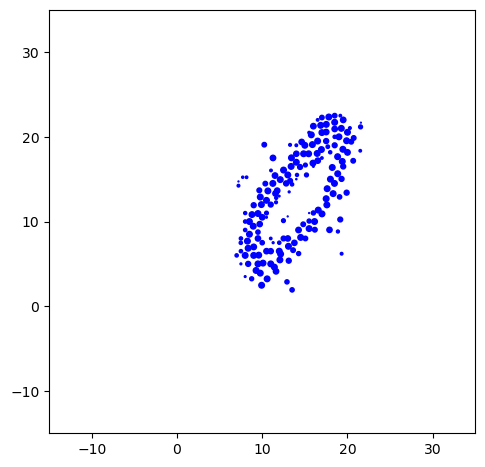

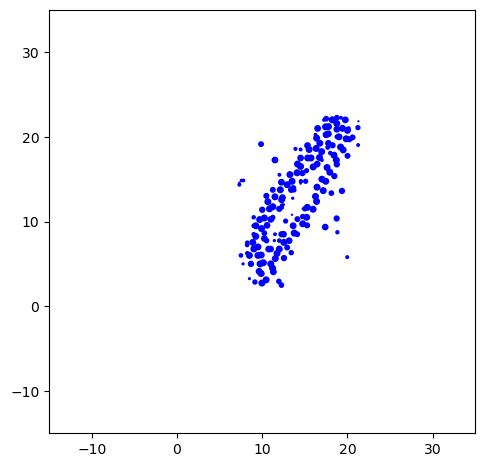

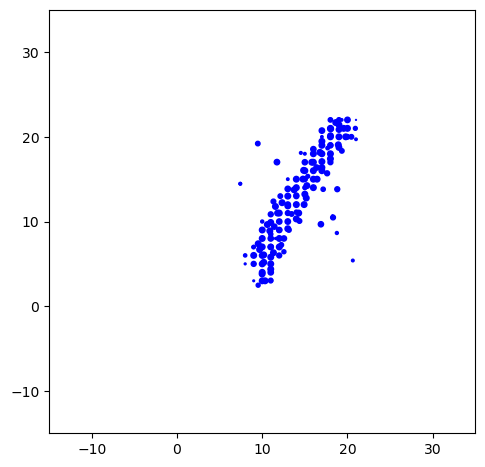

end


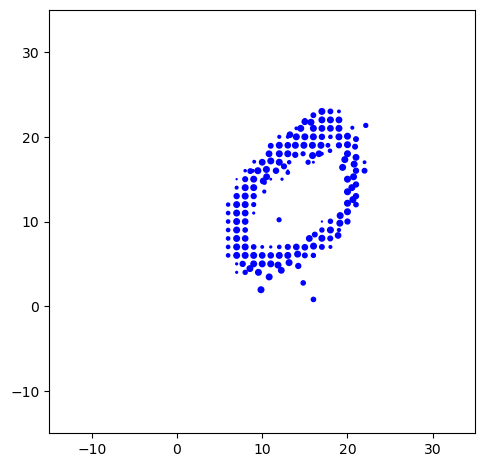

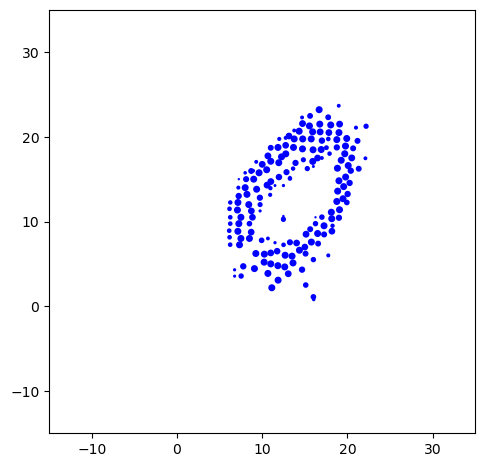

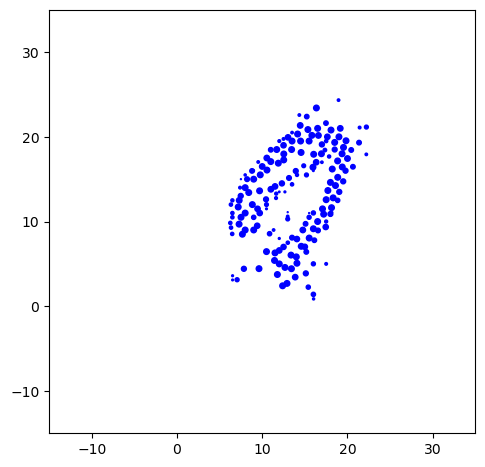

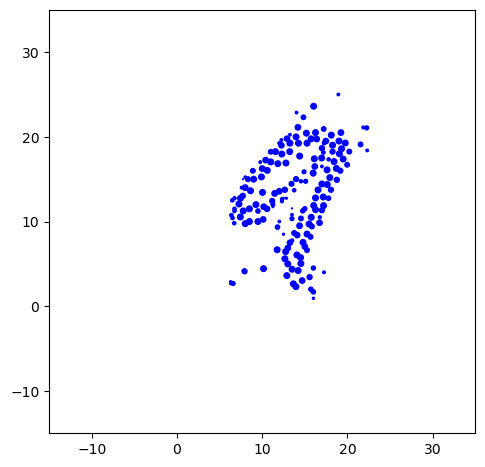

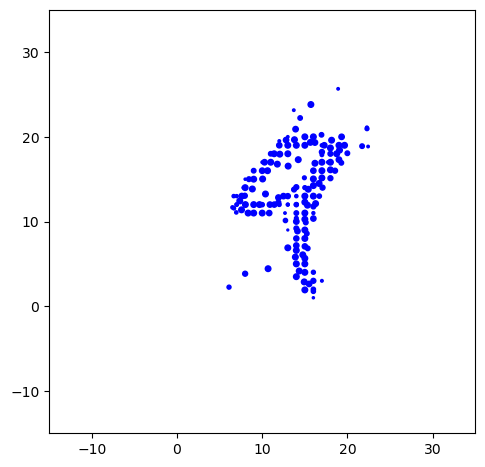

end
label 0.75


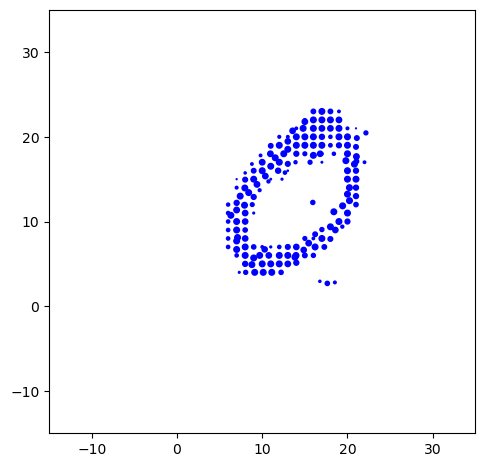

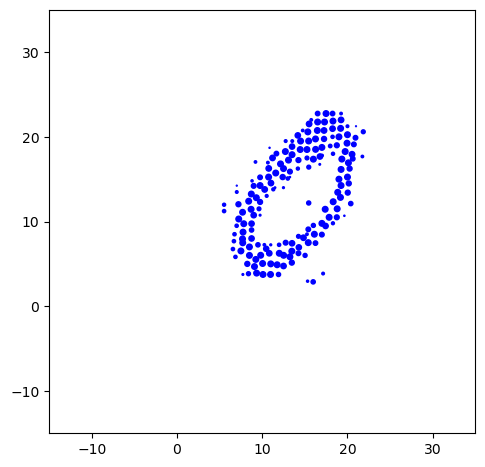

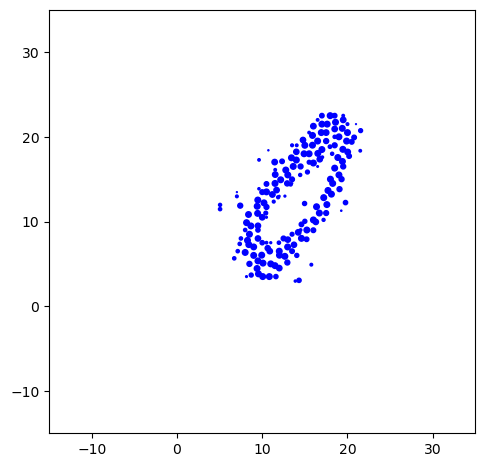

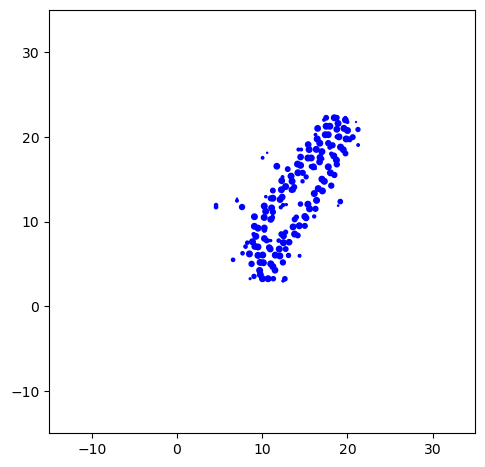

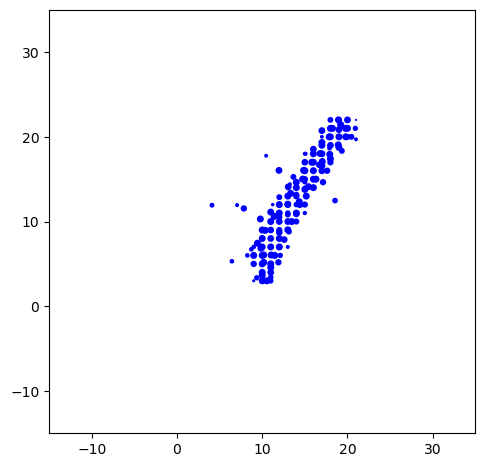

end


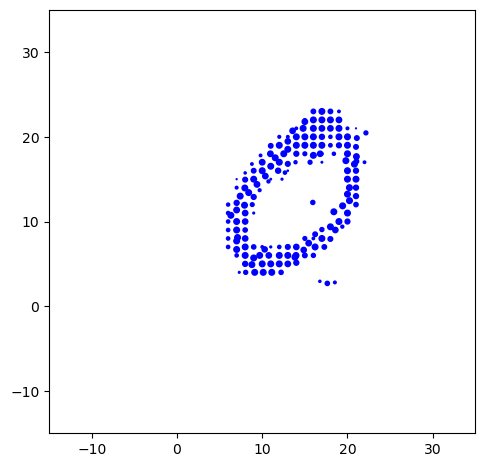

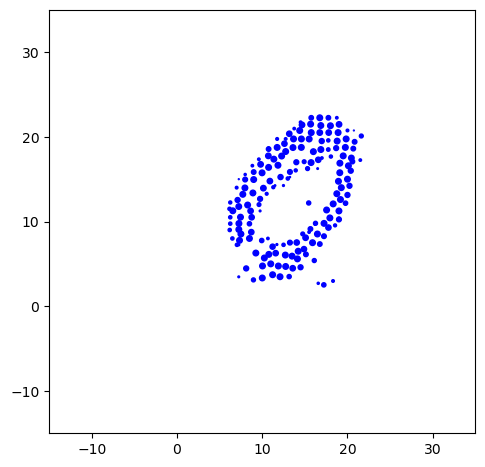

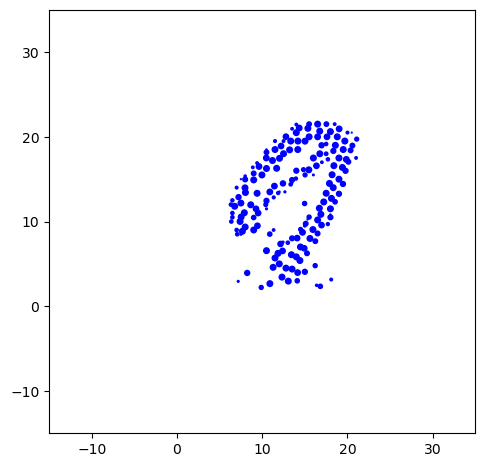

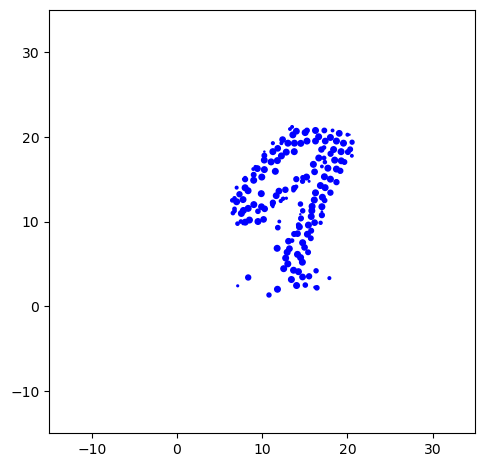

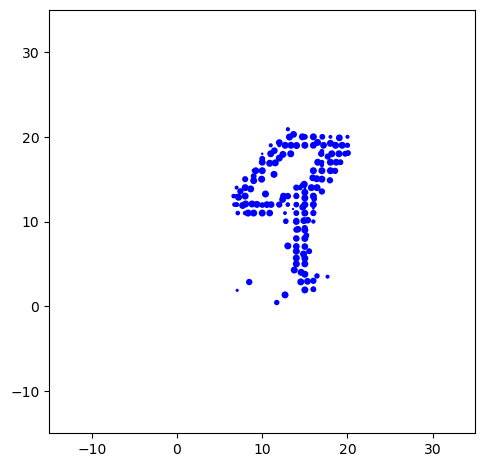

end


In [285]:
#lopt interporlation
tN=5
L=[[0,1],[0,2]]
Lambda=30.0

xlim=(-3,25)
ylim=(-5,25)

#LOT interpolation 
xlim=(-15,35)
ylim=(-15,35)

for label in [0,0.5,0.75]:
    print('label',label)
    lopt_E=list()
    X,p=data_list['data_'+str(label)]
#     # barycenter
#     X1,X2,X3=(X[0],X[1],X[2])
#     p1,p2,p3=(p[0],p[1],p[2])
#     N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
    
#     X0_init=np.random.uniform(low=[5,5],high=[20,20],size=[N0,2])
#     p0=np.ones(N0)/N0

#     #p0=p0/np.sum(p0)
#     Xi_list=[X1,X2,X3]
#     pi_list=[p1/np.sum(p1),p2/np.sum(p2),p3/np.sum(p3)]
#     weights=np.ones(3)/3
#     #X0=lopt_barycenter(Xi_list,pi_list,X0_init,p0, weights,Lambda, numItermax=10000,stopThr=1e-7)
#     X0=lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7)
    
    for k in range(M):
        Xk=X[k]
        pk=p[k]
        Uk,pk_hat,Mk=lopt_embedding(X0,Xk,p0,pk,Lambda)
        lopt_E.append((Uk,pk_hat))
        Uk,pk_hat=lopt_E[-1]
        #scatter_2d(X0+Uk,pk_hat,xlim=xlim,ylim=ylim,name=name)
        
    #torch.save(lopt_E,'experiment/geodesic/result/MNIST/lopt_E'+str(label)+'.pt')
        
    for (i,j) in L:        
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)
        Ui,pi_hat=lopt_E[i]
        Uj,pj_hat=lopt_E[j]
    
        Xt_list,pt,X_d,p_d,X_c,p_c=lopt_interpolation(X0,Ui,Uj,pi_hat,pj_hat,np.linspace(0,1,tN))
        #Xt_list_lopt,=lopt_geodesic(X0,Ui,Uj,np.linspace(0,1,tN))
        ind=0
        lopt_result=list()
        for t in np.linspace(0,1,tN):
            Xt=Xt_list[ind]
            name=save_path+'/X_lopt_t='+str(t)+'.pdf'
            scatter_2d(Xt,pt,X_d=X_d,p_d=(1-t)*p_d,X_c=X_c,p_c=t*p_c,xlim=xlim,ylim=ylim,name=name)
            ind+=1  
            lopt_result.append((Xt,pt,X_d,(1-t)*p_d,X_c,t*p_c))
        
        torch.save(lopt_result,save_path+'/lopt_result.pt')
        print('end')
        



In [8]:
plt.rcParams.update({'font.size': 20})

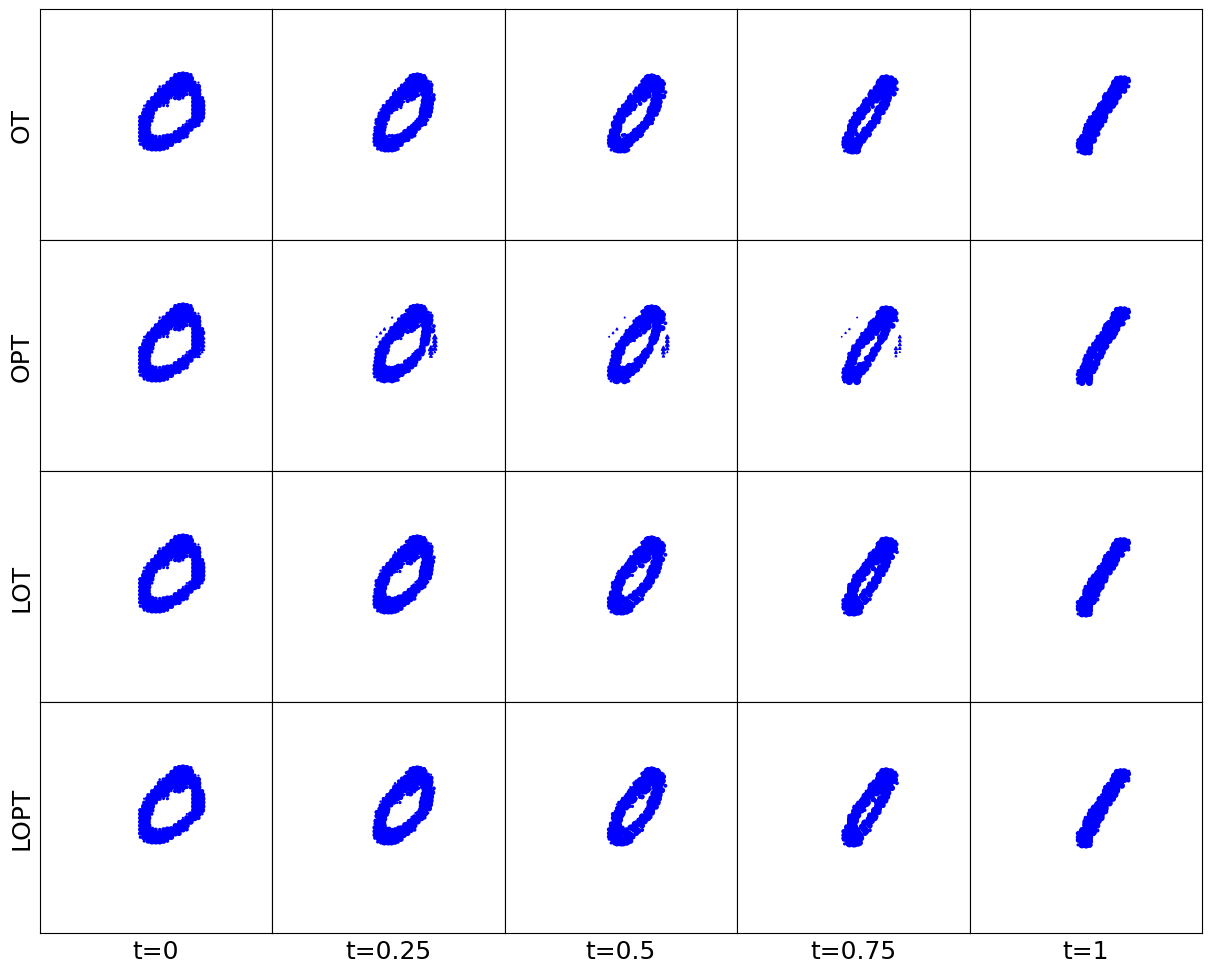

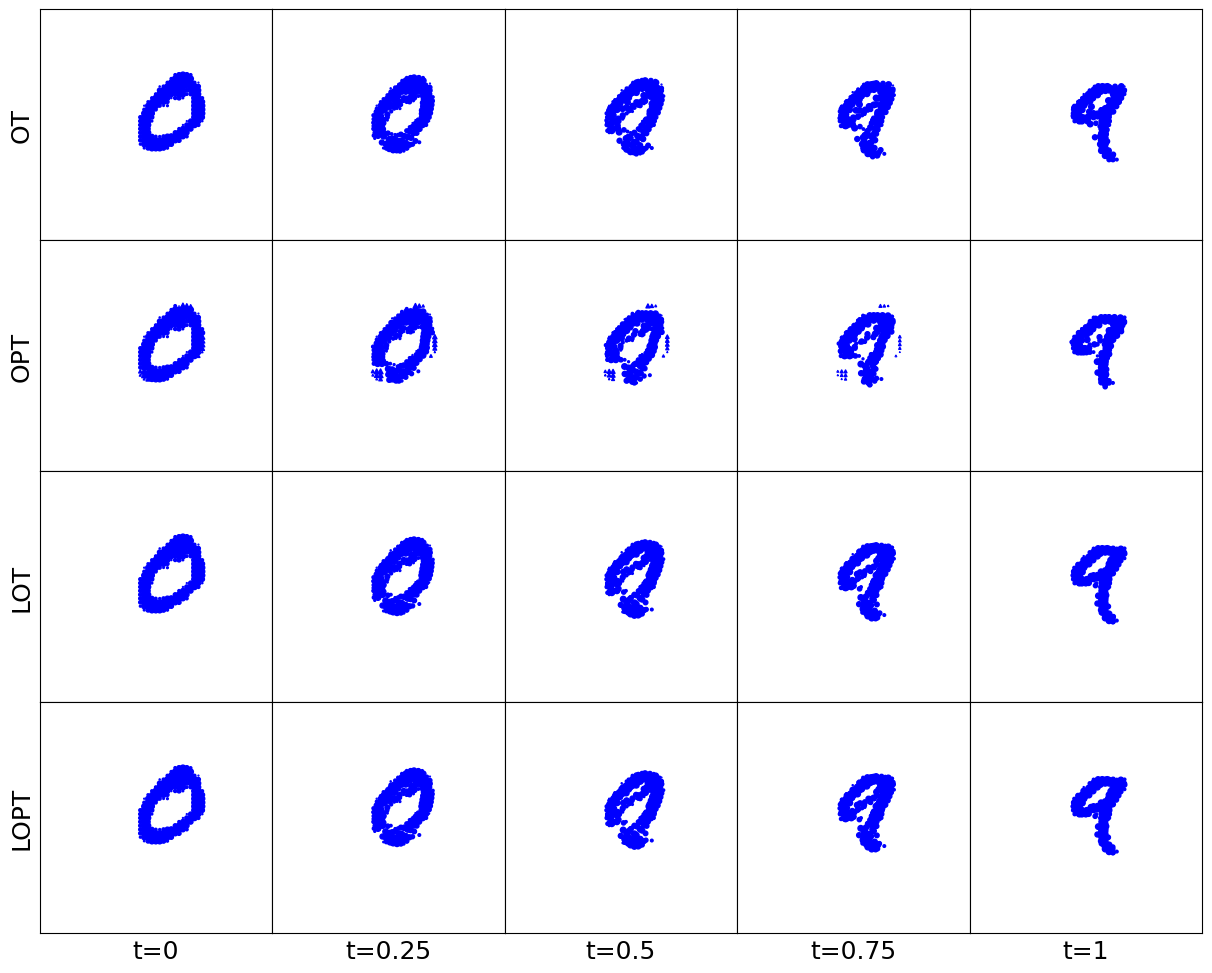

done


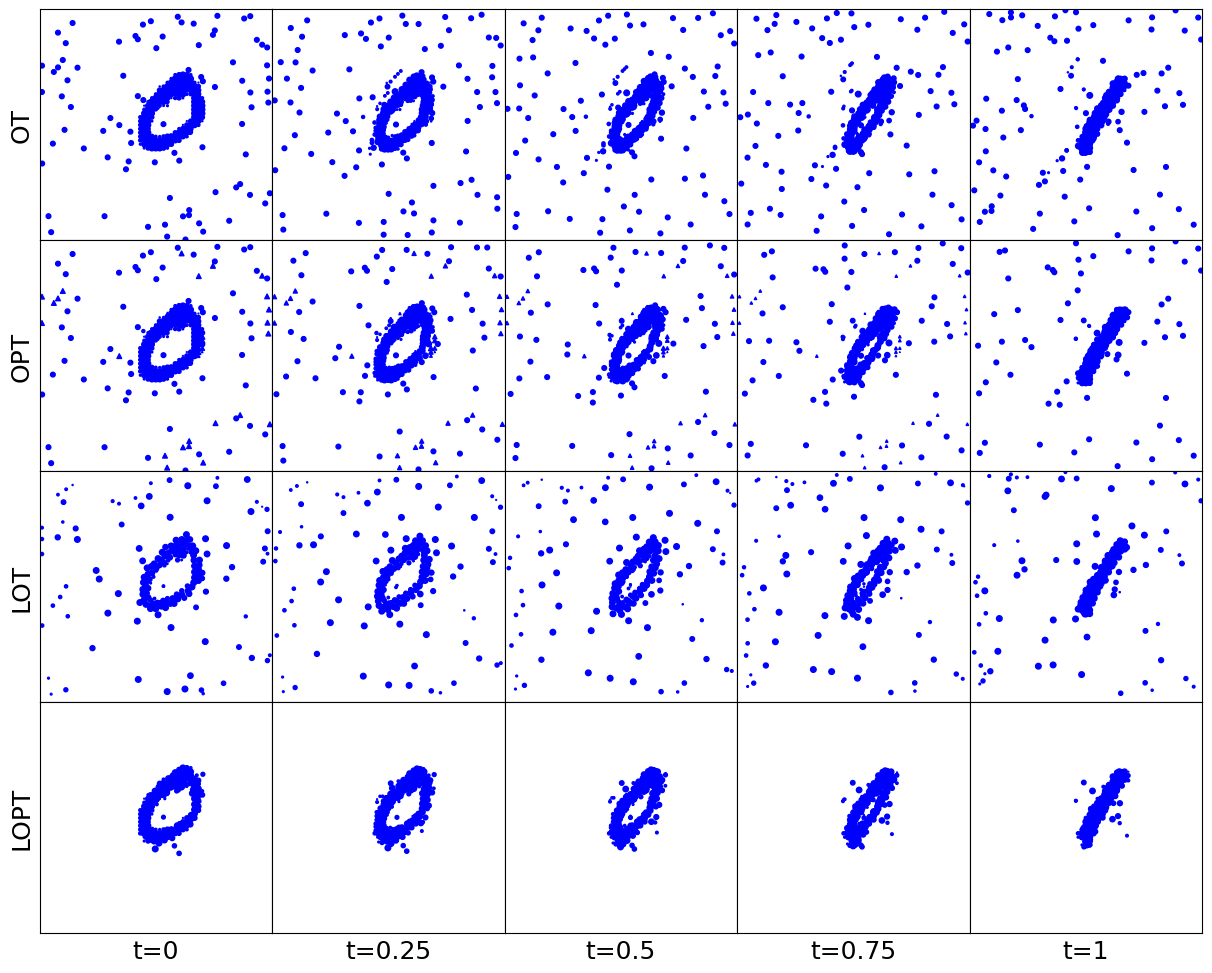

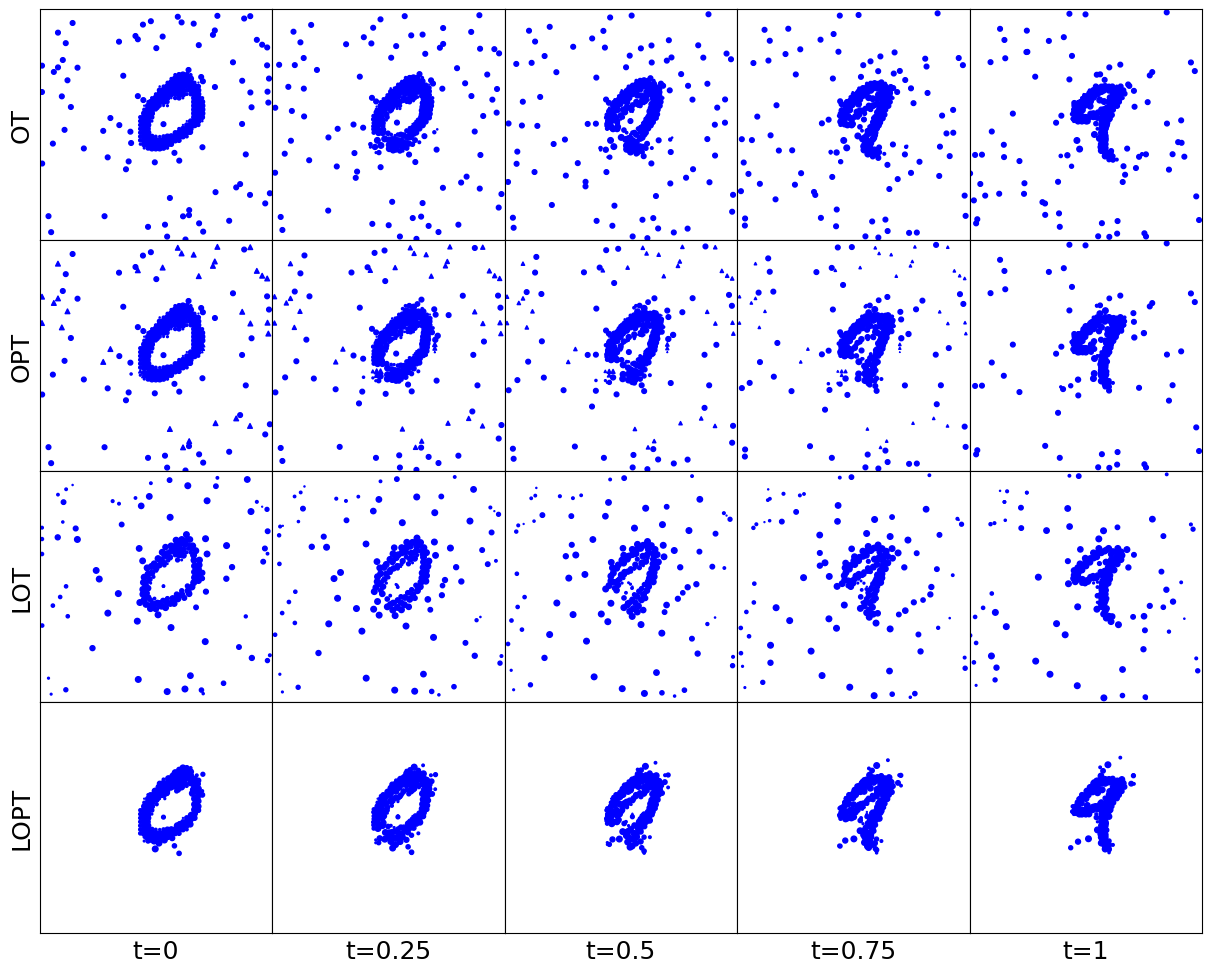

done


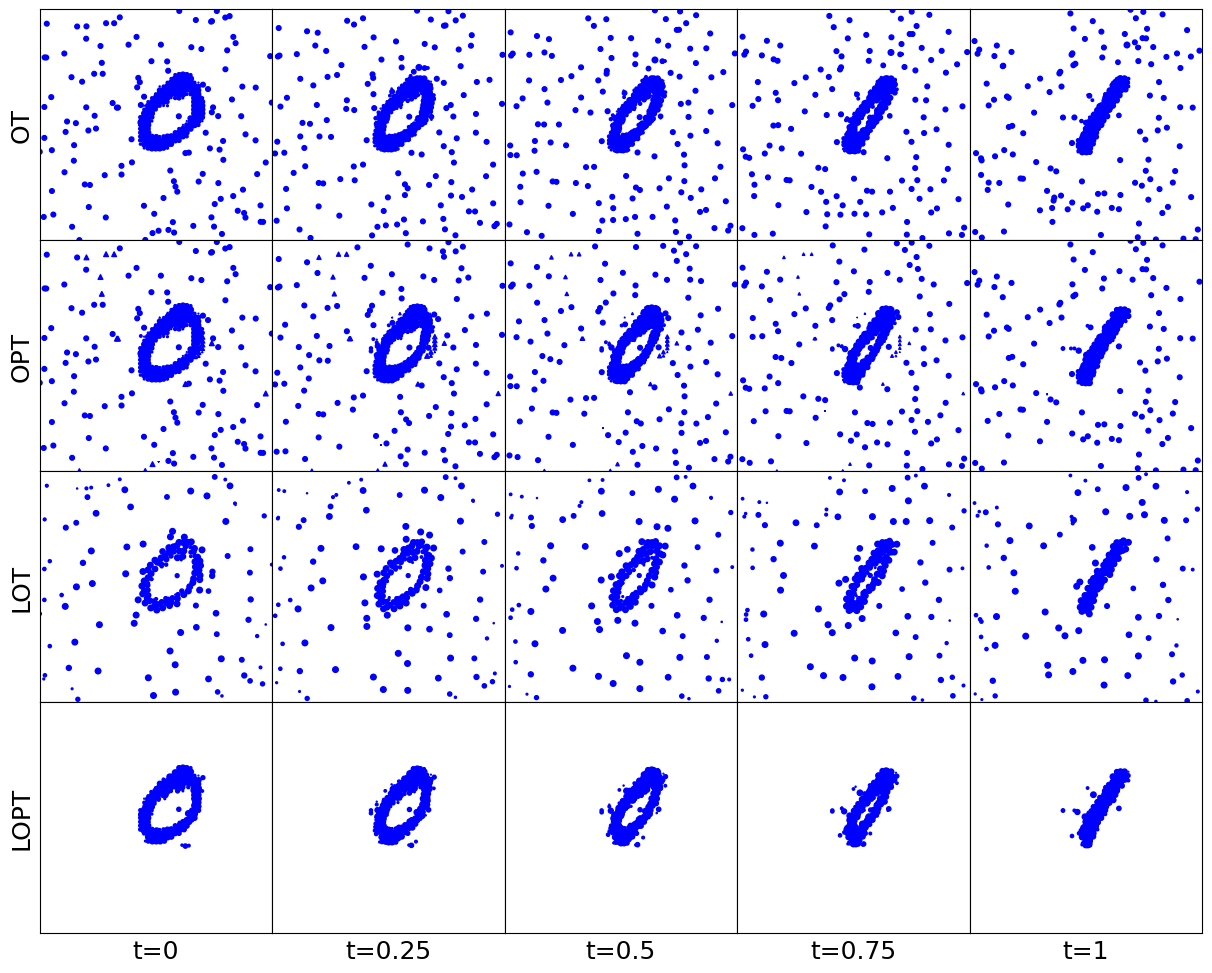

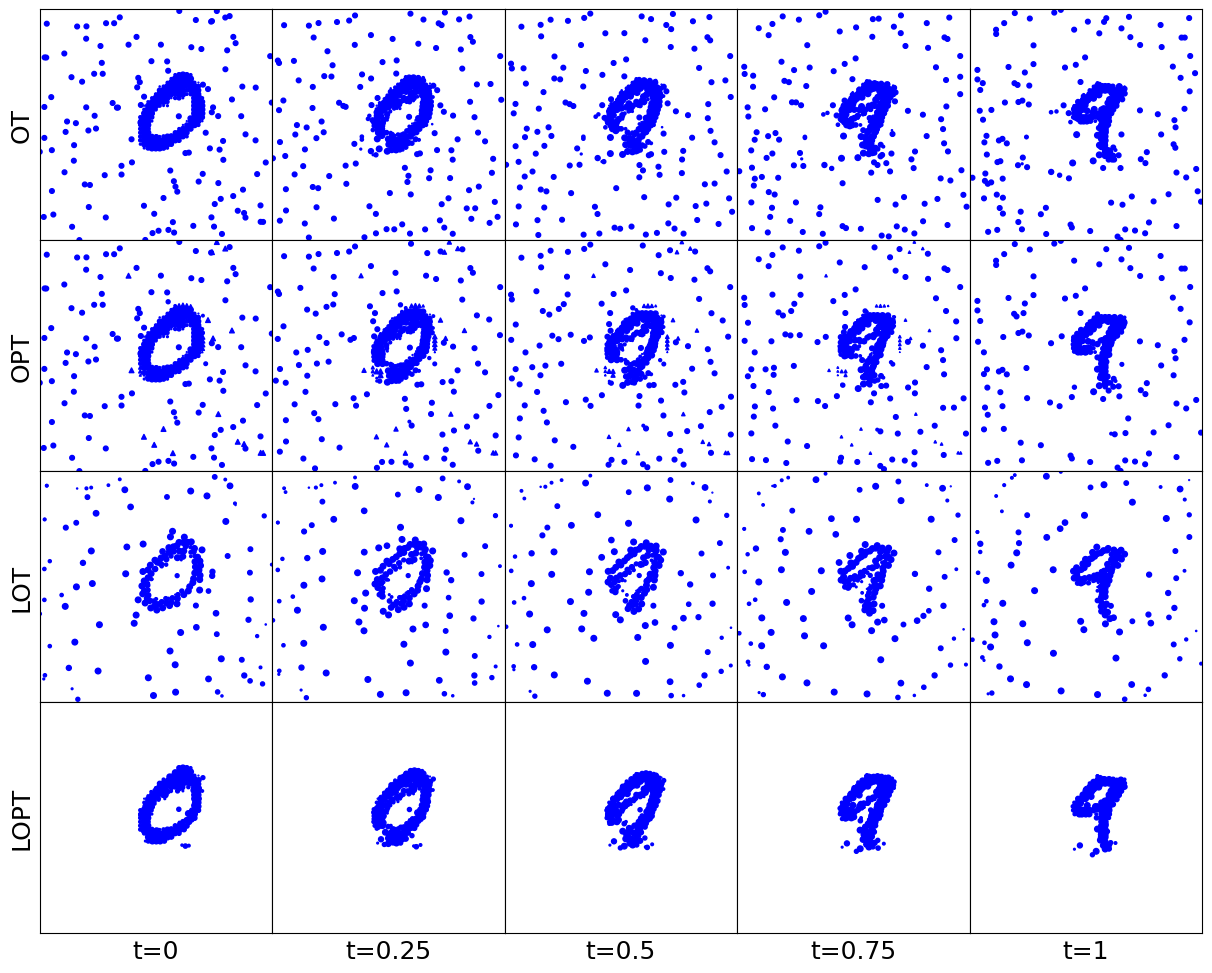

done


In [258]:
# plot the result
method_list=['ot','opt','lot','lopt']
result_path='experiment/geodesic/result/MNIST/'
label_list=['0','0.5','0.75']
ij_list=['01','02']
t_list=['0','0.25','0.5','0.75','1']
row_list=['t=0','t=0.25','t=0.5','t=0.75','t=1']
save_path='experiment/geodesic/result/MNIST'
xlim=[-20,40]
ylim=[-20,40]
for label in label_list:
    for ij in ij_list:
        fig,ax=plt.subplots(4,5,figsize=(3*5,3*4))
        name='geodesic_'+ij+'_'+label+'.pdf'
        for i in range(4):
            method=method_list[i]
            result_path=save_path+'/'+label+'_'+ij+'/'+method+'_result.pt'
            result=torch.load(result_path)            
            for j in range(5):                
                t=t_list[j]
                if method=='ot':
                    Xt,pt=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,xlim=xlim,ylim=ylim)
                elif method=='opt':
                    Xt,pt,X_d,p_d=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,X_d=X_d,p_d=p_d,xlim=xlim,ylim=ylim)
                elif method=='lot':
                    Xt,pt=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,xlim=xlim,ylim=ylim)
                elif method=='lopt':
                    Xt,pt,X_d,p_d,X_c,p_c=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,X_d=X_d,p_d=p_d,X_c=X_c,p_c=p_c,xlim=xlim,ylim=ylim)
            
                
                # if j==0:
                #     ax[i,j].tick_params(left =False, right = False , labelleft = True ,
                #         labelbottom = False, bottom = False)
                # if i==3:
                #     ax[i,j].tick_params(left = False, right = False , labelleft = False ,
                #         labelbottom = True, bottom = False)

        for a, l in zip(ax[-1], row_list):
            a.set_xlabel(l,fontsize=18)

        for a, method in zip(ax[:,0], method_list):
            a.set_ylabel(method.upper() , rotation=90, fontsize=18)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(save_path+'/'+name,dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        
    print('done')
        